## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import datetime
import plotly.express as px

In [3]:
import warnings

In [4]:
warnings.filterwarnings('ignore') 

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [7]:
from sklearn.cluster import KMeans

In [8]:
!pip install --upgrade scikit-learn

In [9]:
!pip install holidays

## 2. Dataframe and Characteristics

In [10]:
df = pd.read_csv(r"C:\Users\sastr\Downloads\price_optimsation_dataset.csv")

In [11]:
df.head()

product_id product_category_name  month_year  qty  total_price  \
0       bed1        bed_bath_table  01-05-2017    1        45.95   
1       bed1        bed_bath_table  01-06-2017    3       137.85   
2       bed1        bed_bath_table  01-07-2017    6       275.70   
3       bed1        bed_bath_table  01-08-2017    4       183.80   
4       bed1        bed_bath_table  01-09-2017    2        91.90   

   freight_price  unit_price  product_name_lenght  product_description_lenght  \
0      15.100000       45.95                   39                         161   
1      12.933333       45.95                   39                         161   
2      14.840000       45.95                   39                         161   
3      14.287500       45.95                   39                         161   
4      15.100000       45.95                   39                         161   

   product_photos_qty  ...  comp_1  ps1        fp1      comp_2  ps2  \
0                   2  ...    89.9  3.9  15.011897  215.000000  4.4   
1                   2  ...    89.9  3.9  14.769216  209.000000  4.4   
2                   2  ...    89.9  3.9  13.993833  205.000000  4.4   
3                   2  ...    89.9  3.9  14.656757  199.509804  4.4   
4                   2  ...    89.9  3.9  18.776522  163.398710  4.4   

         fp2  comp_3  ps3        fp3  lag_price  
0   8.760000   45.95  4.0  15.100000      45.90  
1  21.322000   45.95  4.0  12.933333      45.95  
2  22.195932   45.95  4.0  14.840000      45.95  
3  19.412885   45.95  4.0  14.287500      45.95  
4  24.324687   45.95  4.0  15.100000      45.95  

[5 rows x 30 columns]

In [12]:
df.shape

(676, 30)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

## 3. Preprocessing

**Null value check**

In [14]:
df.isna().sum()

product_id                    0
product_category_name         0
month_year                    0
qty                           0
total_price                   0
freight_price                 0
unit_price                    0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_score                 0
customers                     0
weekday                       0
weekend                       0
holiday                       0
month                         0
year                          0
s                             0
volume                        0
comp_1                        0
ps1                           0
fp1                           0
comp_2                        0
ps2                           0
fp2                           0
comp_3                        0
ps3                           0
fp3                           0
lag_price                     0
dtype: int64

**Duplicate values check**

In [15]:
duplicate = df[df.duplicated(['product_id', 'product_category_name', 'month_year'])]
print("Duplicate Rows :")

Duplicate Rows :


**Datetime conversion**

In [16]:
df['month_year'] = pd.to_datetime(df['month_year'])

**Feature engineering**

In [17]:
df['IsWeekend'] = df['month_year'].dt.weekday >= 5

In [18]:
from datetime import date
import holidays
us_holidays = []

# Print all the holidays in UnitedStates in year 2018
for ptr in holidays.UnitedStates(years = [2017,2018]):
    us_holidays.append(ptr)
    #print(ptr)
print(us_holidays)

[datetime.date(2017, 1, 1), datetime.date(2017, 1, 2), datetime.date(2017, 5, 29), datetime.date(2017, 7, 4), datetime.date(2017, 9, 4), datetime.date(2017, 11, 11), datetime.date(2017, 11, 10), datetime.date(2017, 11, 23), datetime.date(2017, 12, 25), datetime.date(2017, 1, 16), datetime.date(2017, 2, 20), datetime.date(2017, 10, 9), datetime.date(2018, 1, 1), datetime.date(2018, 5, 28), datetime.date(2018, 7, 4), datetime.date(2018, 9, 3), datetime.date(2018, 11, 11), datetime.date(2018, 11, 12), datetime.date(2018, 11, 22), datetime.date(2018, 12, 25), datetime.date(2018, 1, 15), datetime.date(2018, 2, 19), datetime.date(2018, 10, 8)]


In [19]:
df['IsHoliday'] = df['month_year'].isin(us_holidays)

**Outlier visualization and treatment**

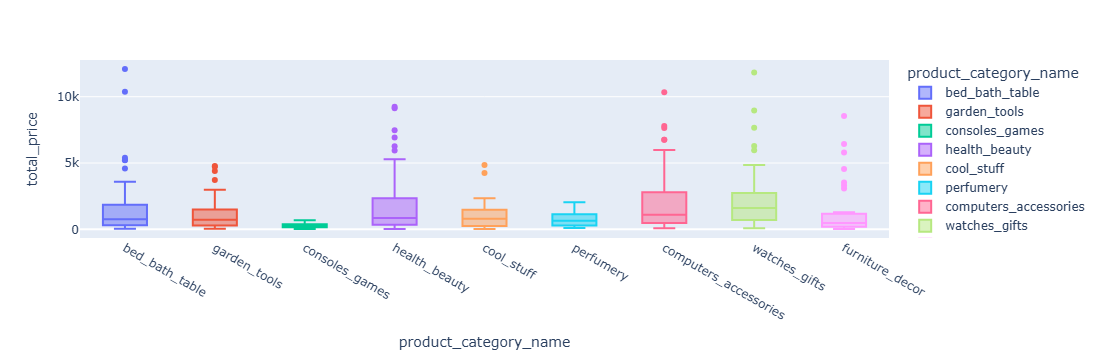

In [20]:
fig = px.box(df, x="product_category_name", y="total_price", color='product_category_name')
fig.show()

In [21]:
def remove_outliers_by_category(df, column, category_column):
    outlier_df = pd.DataFrame()
    non_outlier_df = pd.DataFrame()
    
    for category, group in df.groupby(category_column):
        q1 = group[column].quantile(0.25)
        q3 = group[column].quantile(0.75)

        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        outliers = group[(group[column] < lower_bound) | (group[column] > upper_bound)]
        non_outliers = group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]

        outlier_df = pd.concat([outlier_df, outliers])
        non_outlier_df = pd.concat([non_outlier_df, non_outliers])
    
    return non_outlier_df, outlier_df

# update df_cleaned and df_outliers
df_cleaned, df_outliers = remove_outliers_by_category(df, column='total_price', category_column='product_category_name')


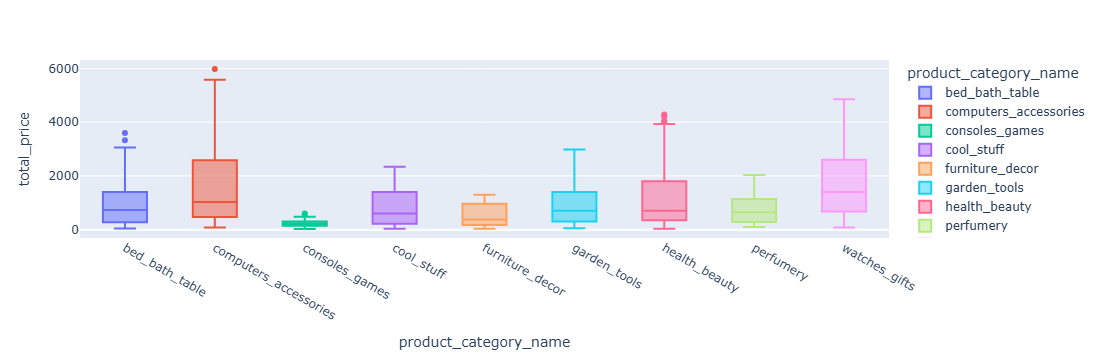

In [22]:
fig = px.box(df_cleaned, x="product_category_name", y="total_price", color='product_category_name')
fig.show()

**Revenue by year**

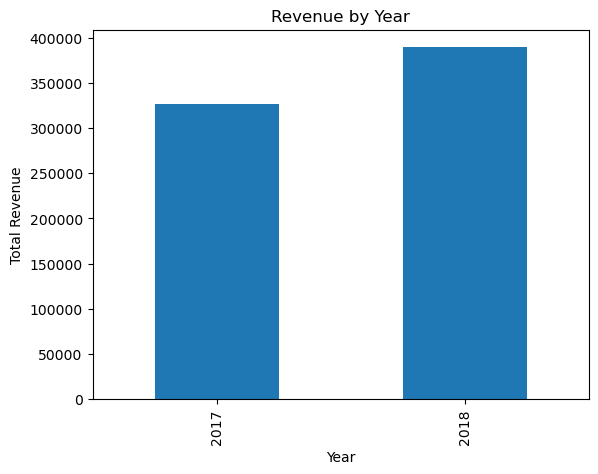

In [23]:
rev_year = df_cleaned.groupby('year')['total_price'].sum().reset_index()
rev_year.plot(kind='bar', x='year', y='total_price', legend=False)

plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.title('Revenue by Year')

plt.show()

In [24]:
rev_year

year  total_price
0  2017    326216.89
1  2018    389289.89

**Revenue by product category**

In [25]:
df_cleaned.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'freight_price', 'unit_price', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3', 'lag_price', 'IsWeekend', 'IsHoliday'],
      dtype='object')

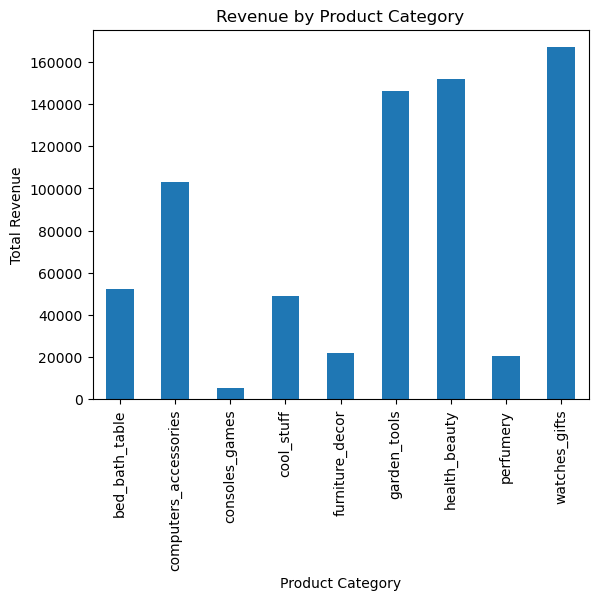

In [26]:
prod_year = df_cleaned.groupby('product_category_name')['total_price'].sum().reset_index()
prod_year.plot(kind='bar', x='product_category_name', y='total_price', legend=False)

plt.xlabel('Product Category')
plt.ylabel('Total Revenue')
plt.title('Revenue by Product Category')

plt.show()

**Sales volume by year - No of units sold**

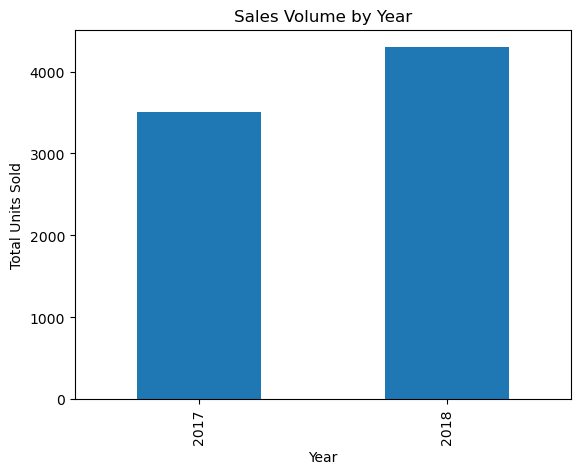

In [27]:
sales_year = df_cleaned.groupby('year')['qty'].sum().reset_index()
sales_year.plot(kind='bar', x='year', y='qty', legend=False)

plt.xlabel('Year')
plt.ylabel('Total Units Sold')
plt.title('Sales Volume by Year')

plt.show()

**Average price by Product Category**

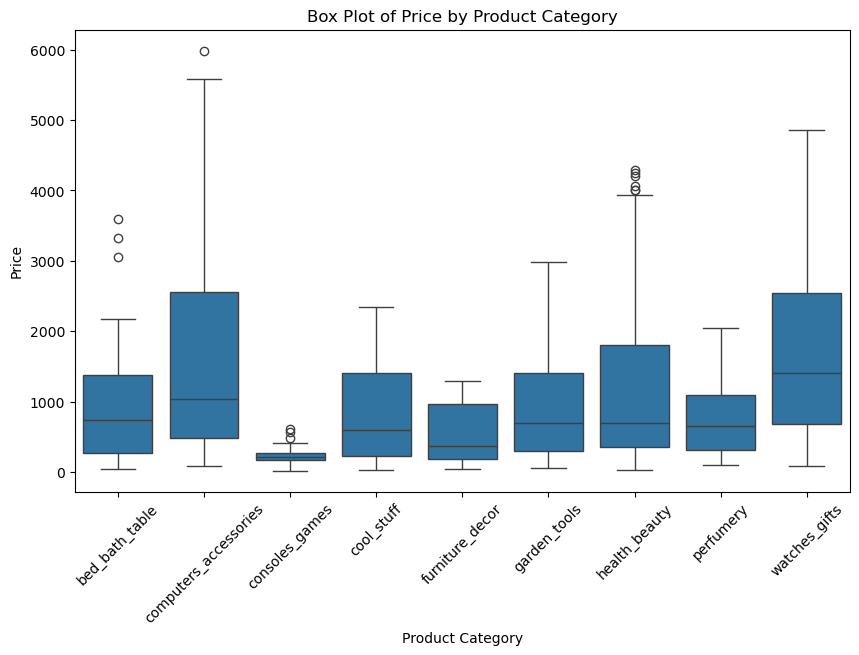

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='product_category_name', y='total_price', data=df_cleaned)

# Adding labels and title for clarity
plt.xlabel('Product Category')
plt.ylabel('Price')
plt.title('Box Plot of Price by Product Category')

# Rotating x-axis labels if they are too long
plt.xticks(rotation=45)

plt.show()

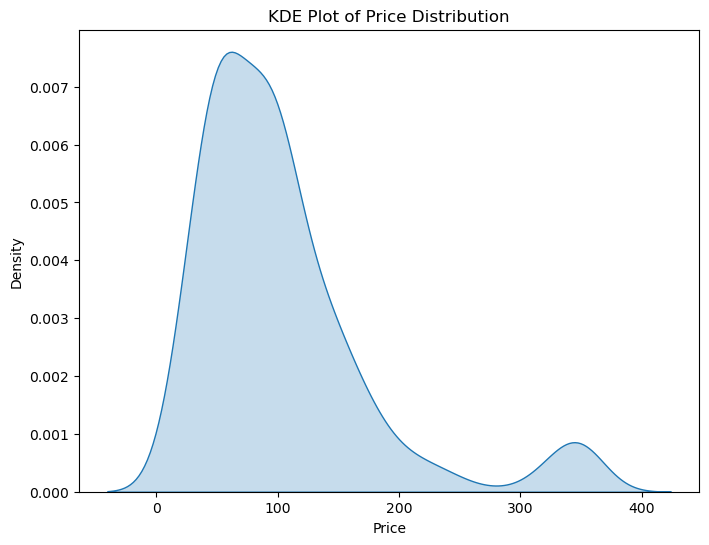

In [29]:
plt.figure(figsize=(8, 6))
sns.kdeplot(df_cleaned['unit_price'], shade=True)

# Adding labels and title
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('KDE Plot of Price Distribution')

plt.show()

## 4. Competitor Analysis

**Correlation analysis**

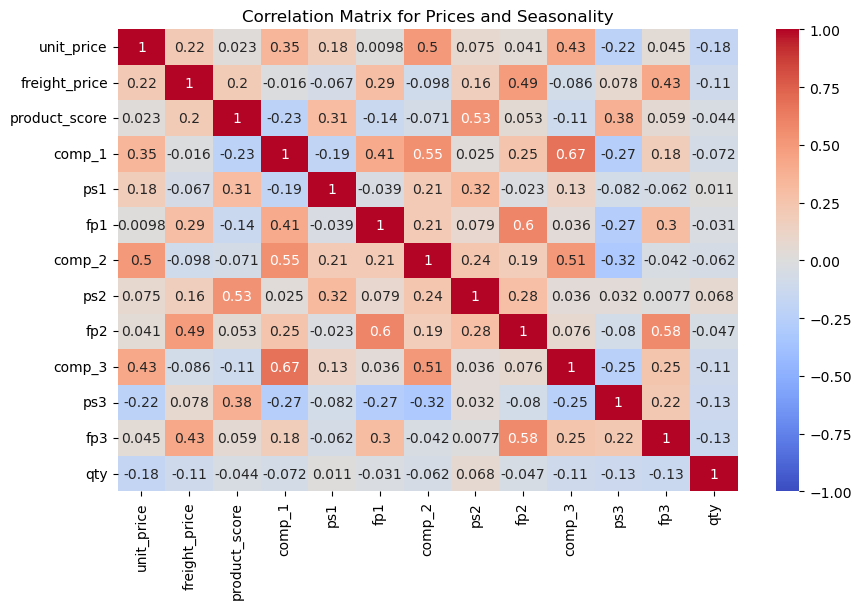

In [30]:
columns_for_corr = ['unit_price', 'freight_price','product_score','comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3','qty']
correlation_matrix = df_cleaned[columns_for_corr].corr()


plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Prices and Seasonality')
plt.show()

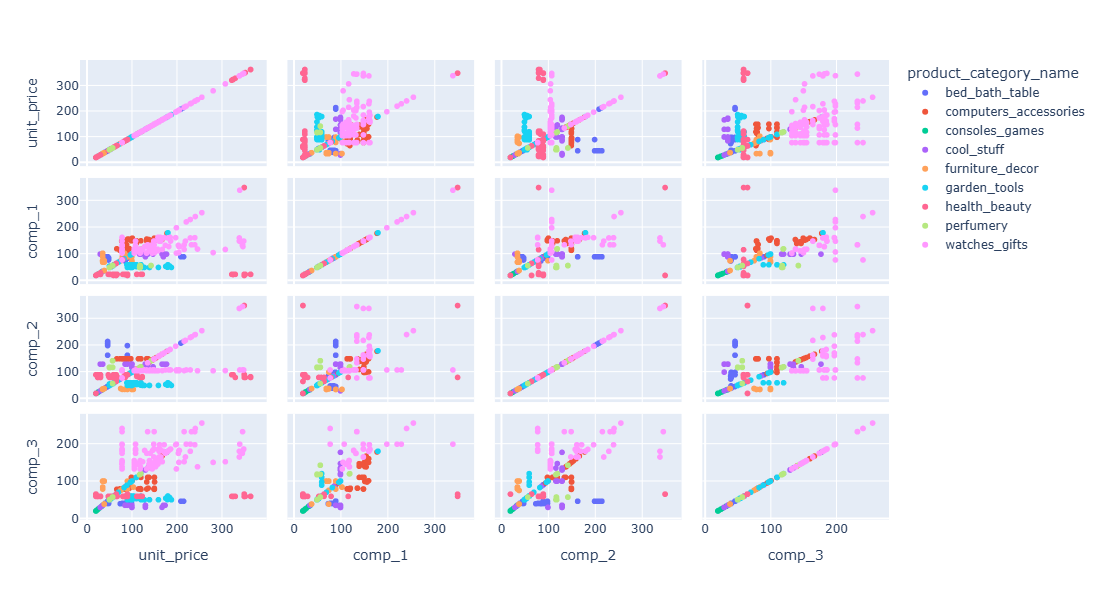

In [31]:
fig = px.scatter_matrix(df_cleaned, 
                        dimensions= ['unit_price', 'comp_1', 'comp_2', 'comp_3'], 
                        color='product_category_name')
fig.update_layout(width=1000, height=600) 
fig.show()

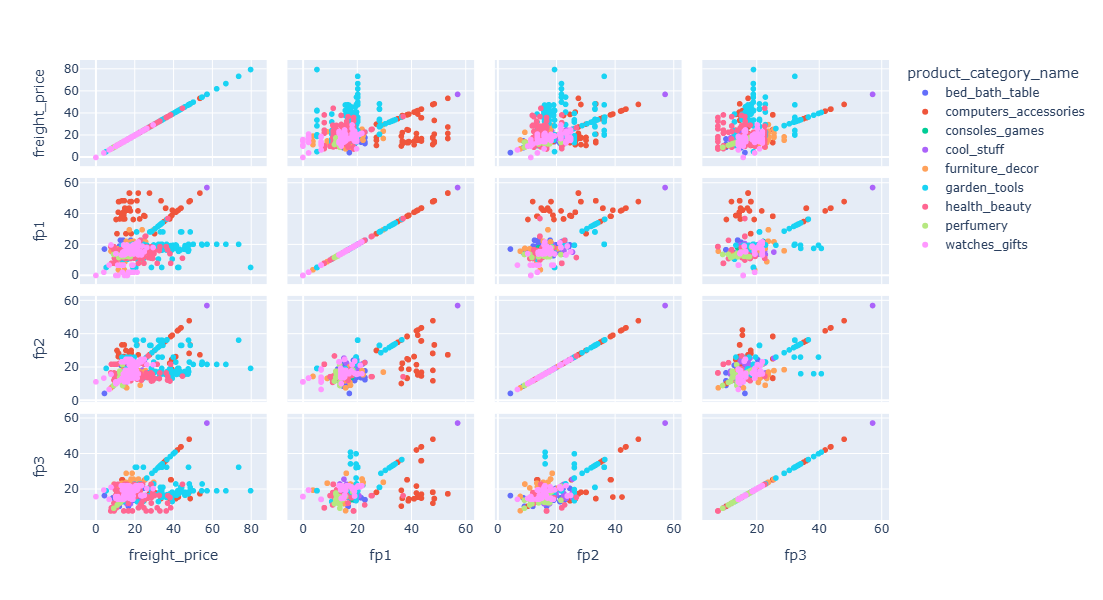

In [32]:
fig = px.scatter_matrix(df_cleaned, 
                        dimensions= ['freight_price', 'fp1', 'fp2', 'fp3'], 
                        color='product_category_name')
fig.update_layout(width=1000, height=600) 
fig.show()

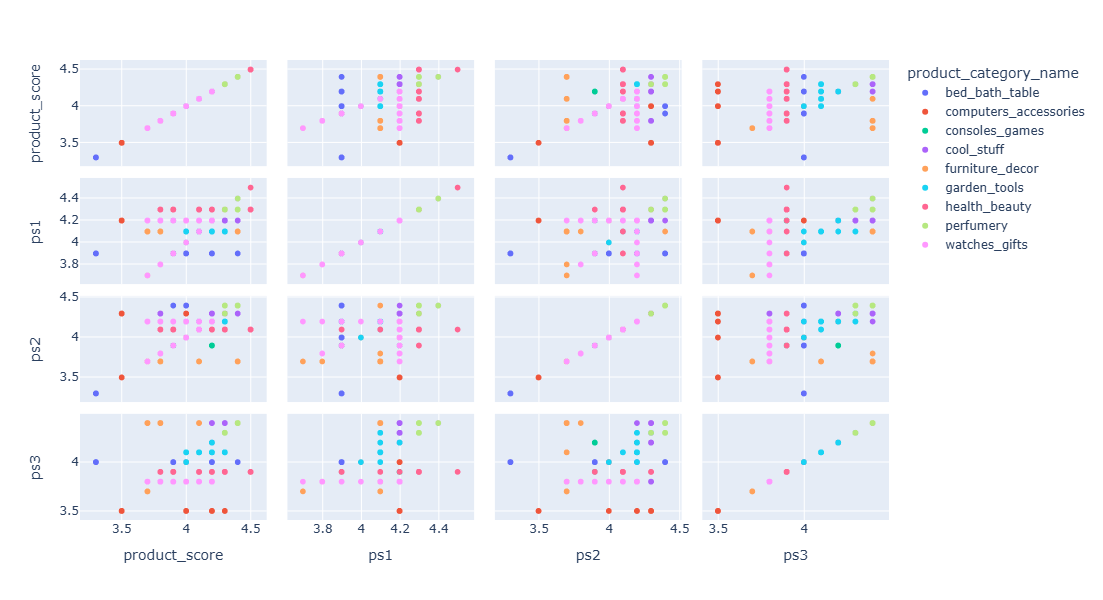

In [33]:
fig = px.scatter_matrix(df_cleaned, 
                        dimensions= ['product_score', 'ps1',  'ps2', 'ps3'], 
                        color='product_category_name')
fig.update_layout(width=1000, height=600) 
fig.show()

**Time series analysis**

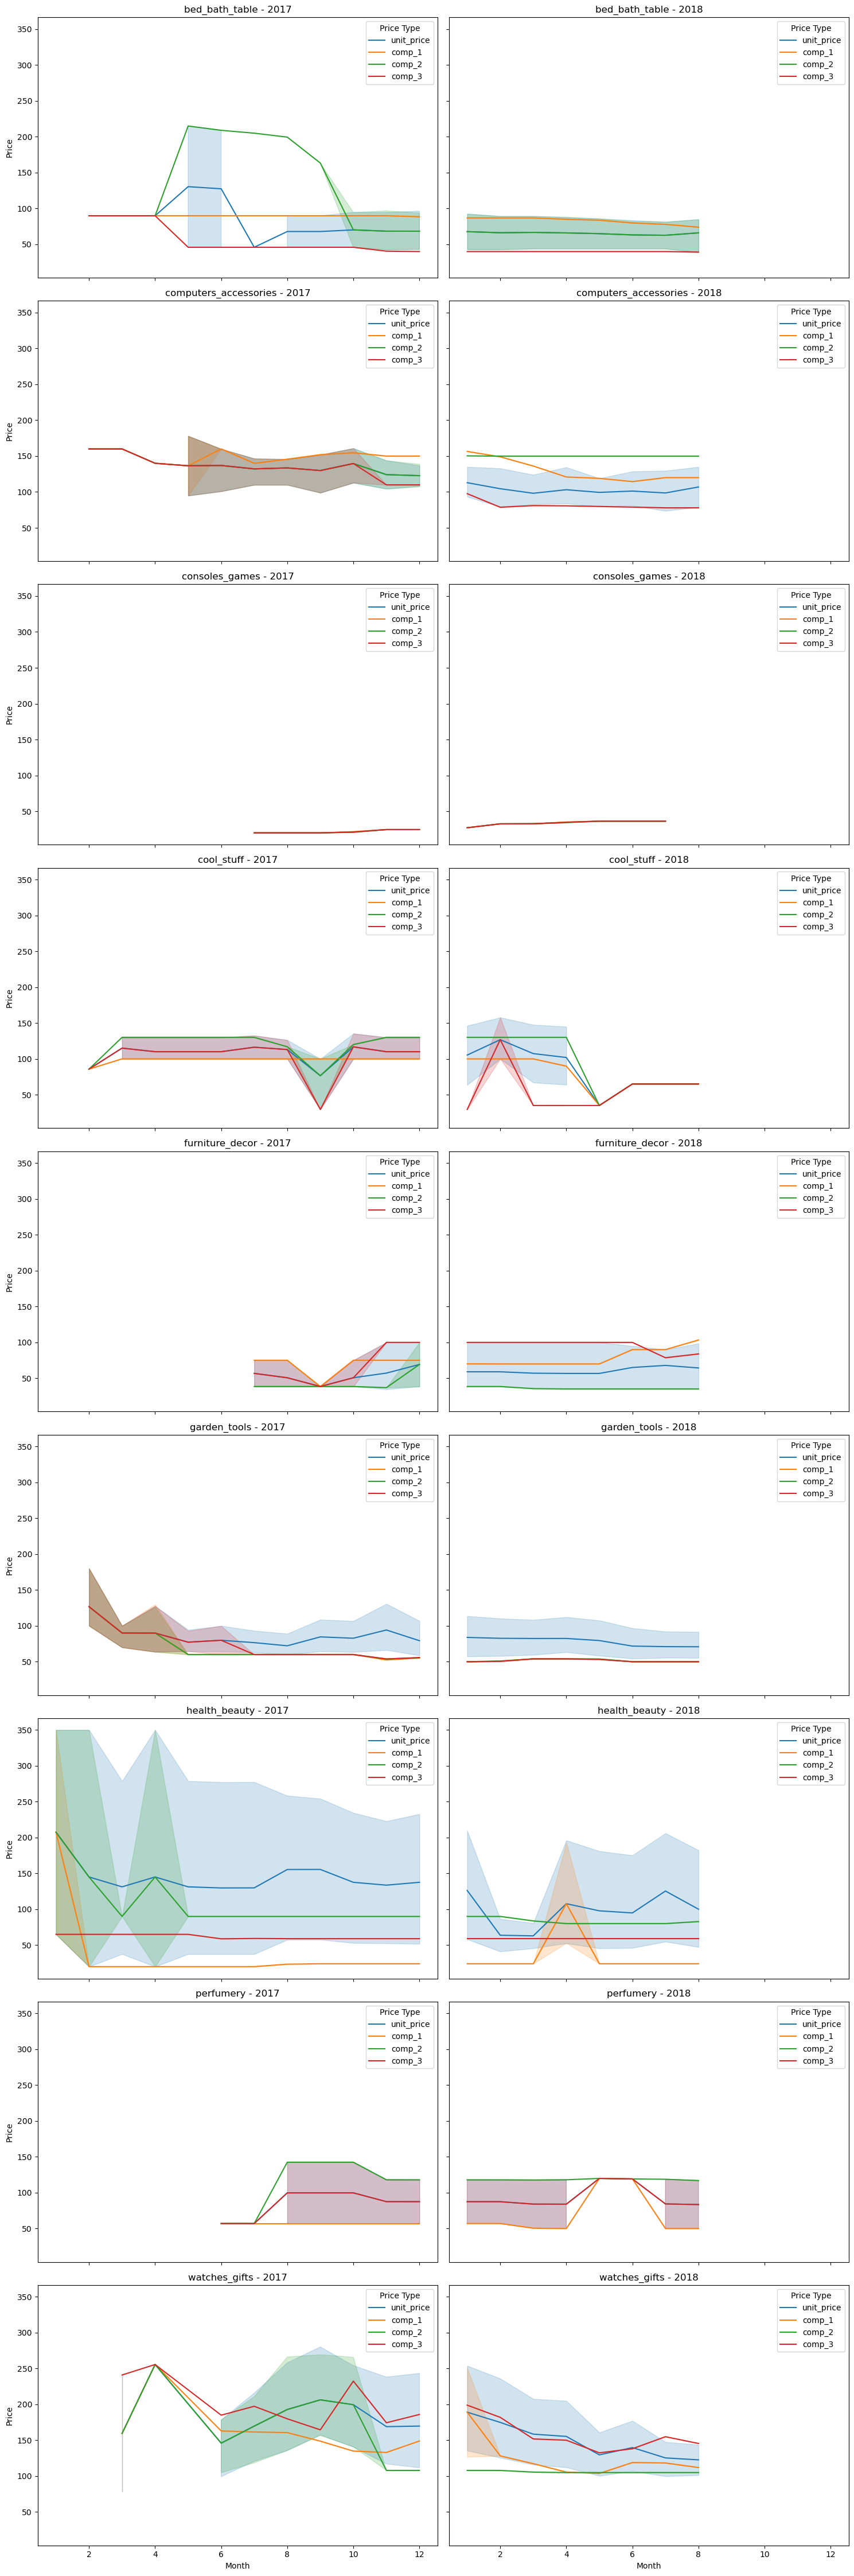

In [34]:
comp_price = df_cleaned.groupby(['year','month','product_category_name'])[['unit_price','comp_1','comp_2','comp_3']].mean().reset_index()
categories = df_cleaned['product_category_name'].unique()
years = df_cleaned['year'].unique()

fig, axs = plt.subplots(len(categories), len(years), figsize=(15, len(categories) * 5), sharex=True, sharey=True)
axs = axs.flatten() if len(categories) > 1 else [axs]

plot_index = 0
for category in categories:
    for year in years:
        category_df = df_cleaned[(df_cleaned['product_category_name'] == category) & (df_cleaned['year'] == year)]
        if not category_df.empty:
            melted_df = pd.melt(category_df, id_vars=['month'], 
                                value_vars=['unit_price', 'comp_1', 'comp_2', 'comp_3'],
                                var_name='Price Type', value_name='Price')
            sns.lineplot(data=melted_df, x='month', y='Price', hue='Price Type', ax=axs[plot_index])
            axs[plot_index].set_title(f'{category} - {year}')
            axs[plot_index].set_xlabel('Month')
            axs[plot_index].set_ylabel('Price')
        
        plot_index += 1
plt.tight_layout()
plt.show()

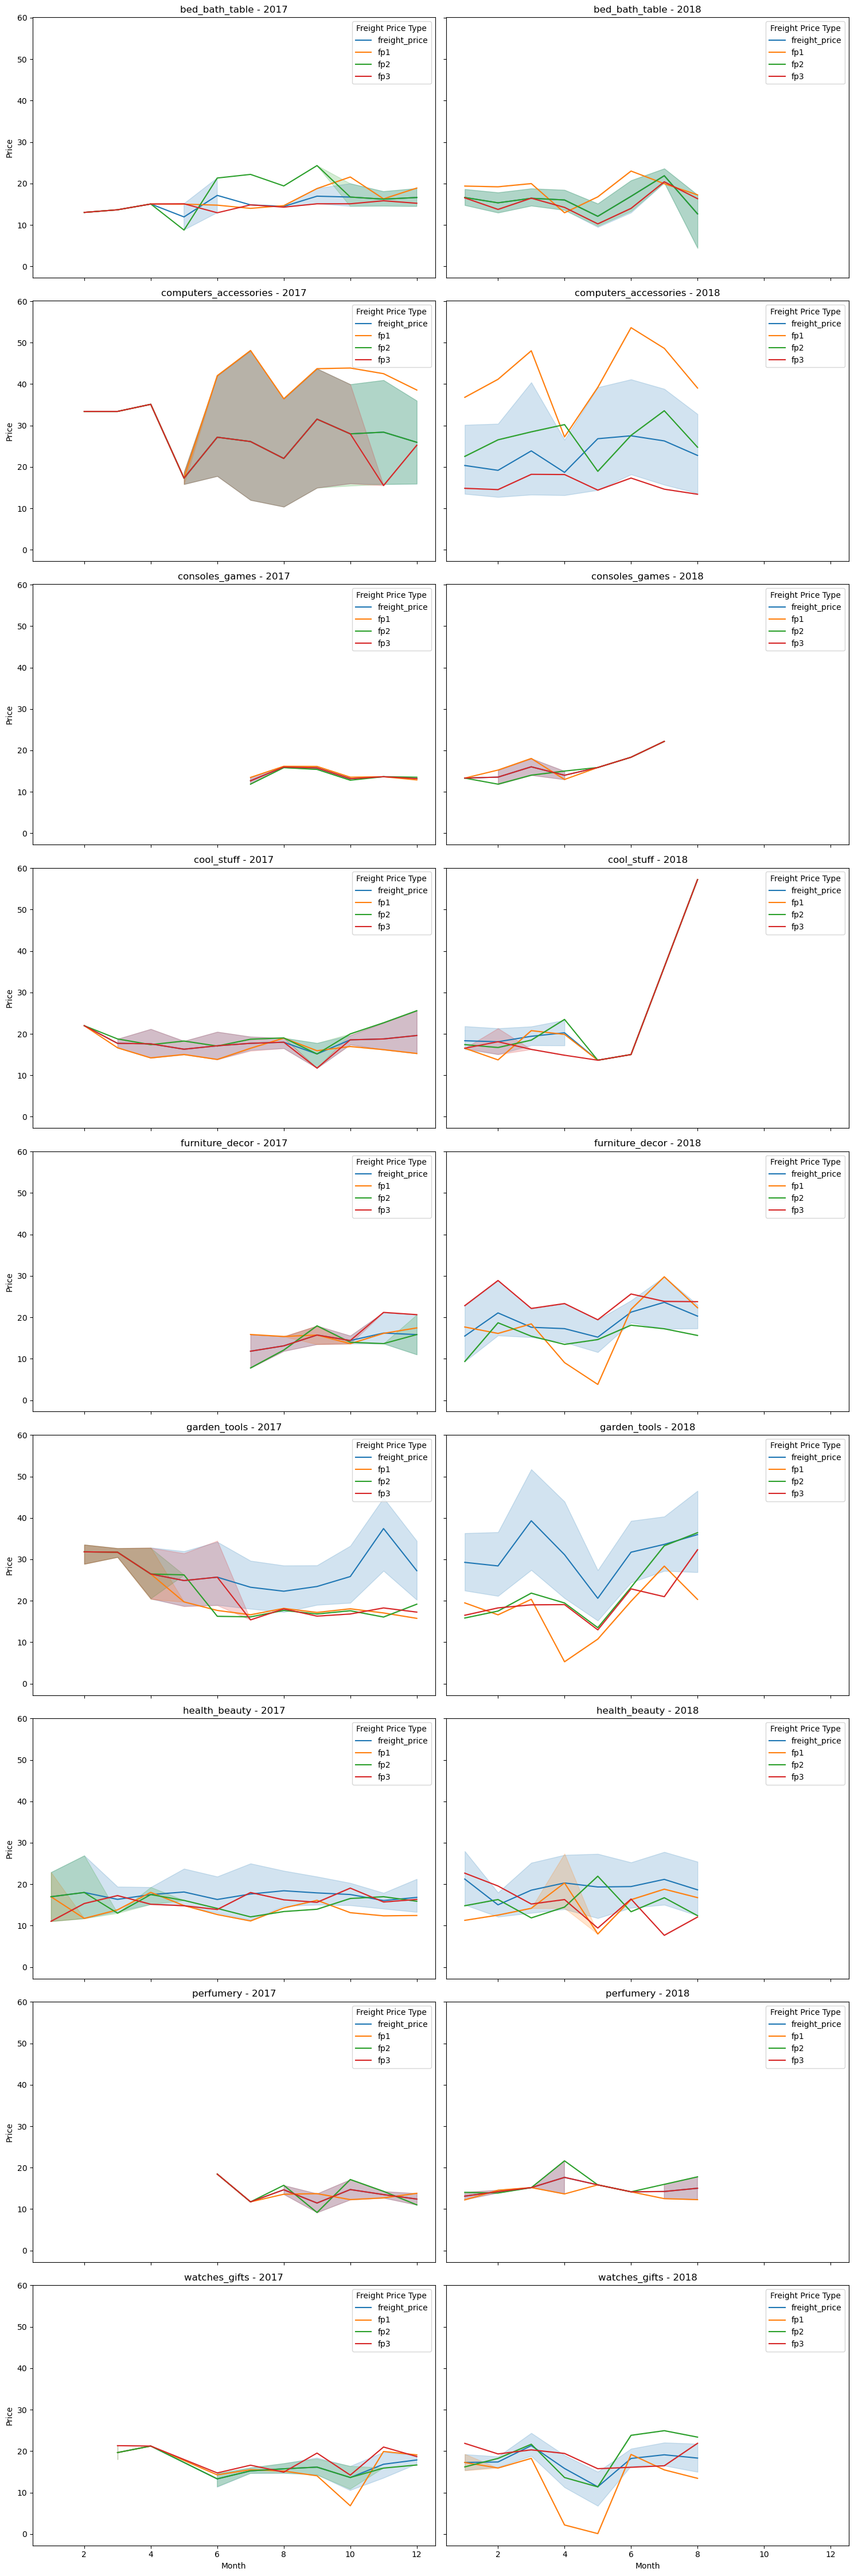

In [35]:
#freight_price = df_cleaned.groupby(['year','month','product_category_name'])[['freight_price','fp1','fp2','fp3']].mean().reset_index()
categories = df_cleaned['product_category_name'].unique()
years = df_cleaned['year'].unique()

fig, axs = plt.subplots(len(categories), len(years), figsize=(15, len(categories) * 5), sharex=True, sharey=True)
axs = axs.flatten() if len(categories) > 1 else [axs]

plot_index = 0
for category in categories:
    for year in years:
        category_df = df_cleaned[(df_cleaned['product_category_name'] == category) & (df_cleaned['year'] == year)]
        if not category_df.empty:
            melted_df = pd.melt(category_df, id_vars=['month'], 
                                value_vars=['freight_price','fp1','fp2','fp3'],
                                var_name='Freight Price Type', value_name='Price')
            sns.lineplot(data=melted_df, x='month', y='Price', hue='Freight Price Type', ax=axs[plot_index])
            axs[plot_index].set_title(f'{category} - {year}')
            axs[plot_index].set_xlabel('Month')
            axs[plot_index].set_ylabel('Price')
        
        plot_index += 1
plt.tight_layout()
plt.show()

## 5. Seasonality and Temporal Analysis

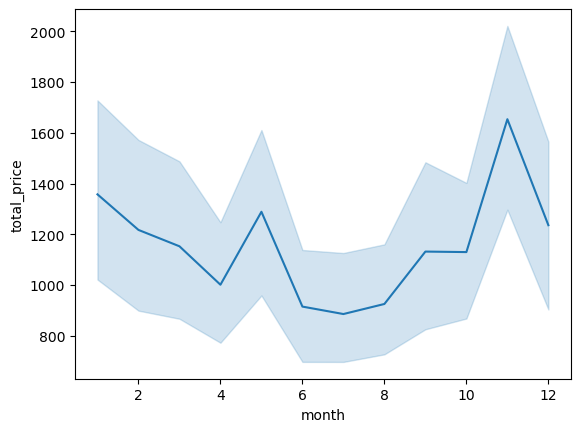

In [36]:
sns.lineplot(x = 'month', y = 'total_price', data = df_cleaned)
plt.show()

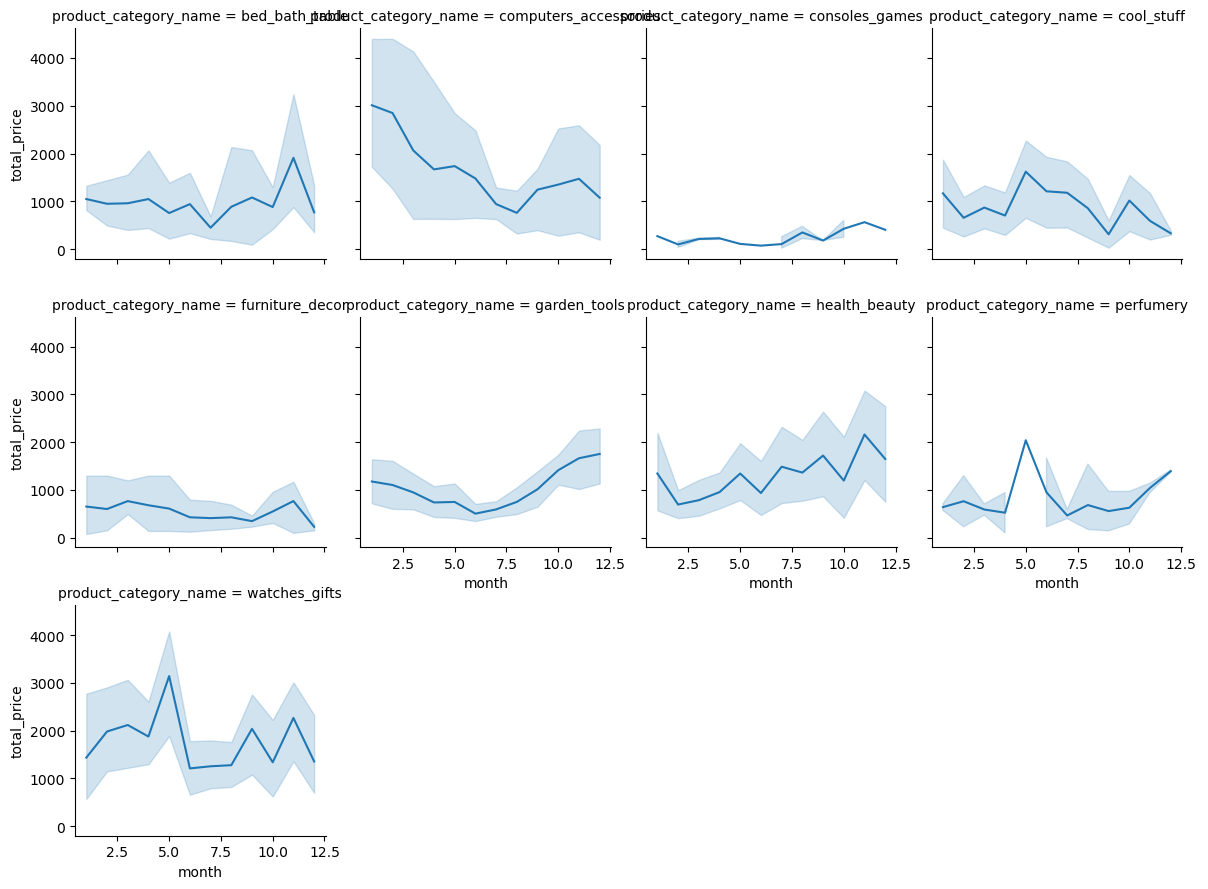

In [37]:
g = sns.FacetGrid(df_cleaned, col='product_category_name', col_wrap=4, height=3)
g.map(sns.lineplot, 'month', 'total_price')
g.add_legend()
plt.show()

**Revenue by individual product**

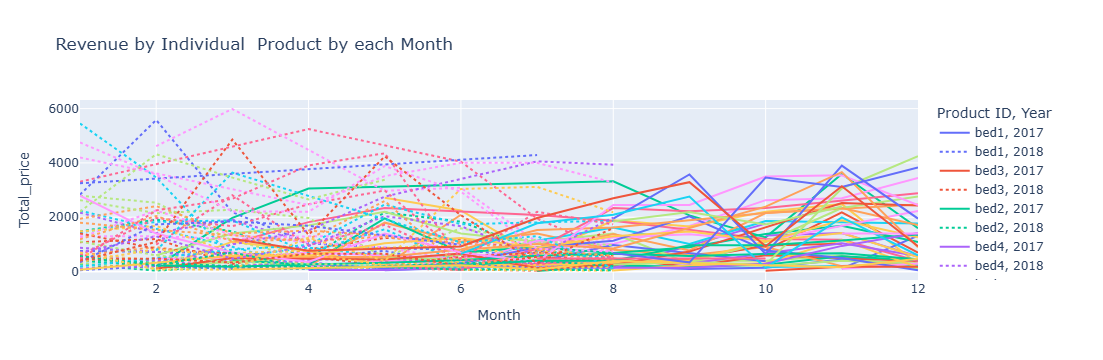

In [38]:
fig = px.line(df_cleaned, x='month', y='total_price', color='product_id', line_dash='year',
              title='Revenue by Individual  Product by each Month',
              labels={'month': 'Month', 'total_price': 'Total_price', 'product_id': 'Product ID', 'year': 'Year'})

fig.show()

**Quantity by individual product**

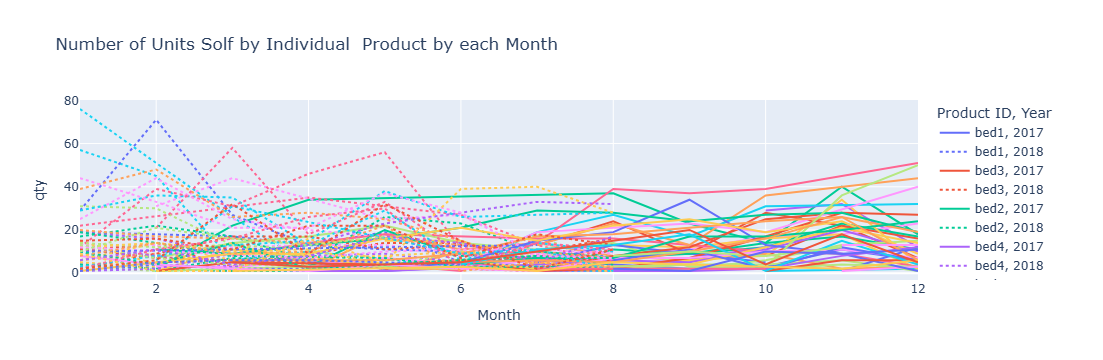

In [39]:
fig = px.line(df_cleaned, x='month', y='qty', color='product_id', line_dash='year',
              title='Number of Units Solf by Individual  Product by each Month',
              labels={'month': 'Month', 'total_price': 'Total_price', 'product_id': 'Product ID', 'year': 'Year'})

fig.show()

**Effect of seasonality column**

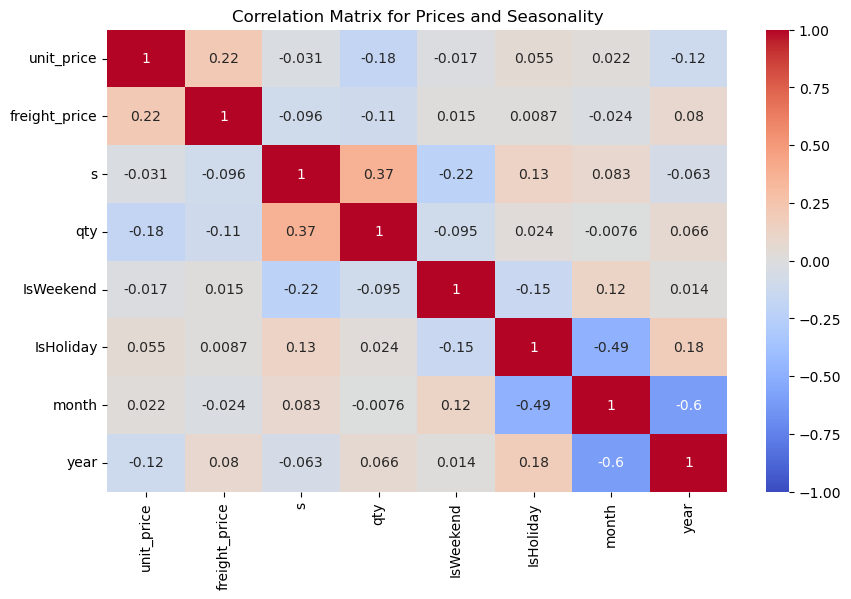

In [40]:
columns_for_corr = ['unit_price', 'freight_price',  's','qty','IsWeekend', 'IsHoliday','month','year']
correlation_matrix = df_cleaned[columns_for_corr].corr()


plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Prices and Seasonality')
plt.show()

**Holiday impact**

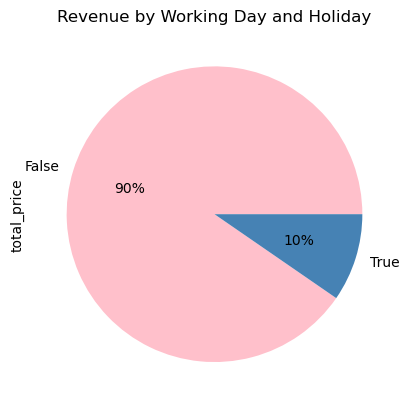

In [41]:
res1 = df_cleaned.groupby(['IsHoliday'])['total_price'].sum().plot(kind='pie', y='total_price', autopct='%1.0f%%',
                                colors = [ 'pink', 'steelblue'],
                                title='Revenue by Working Day and Holiday')
#res1

**Weekday vs Weekend Sales**

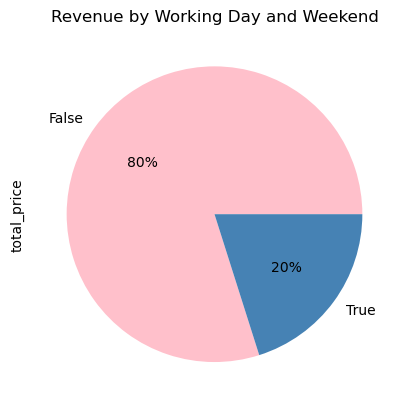

In [42]:
res2 = df_cleaned.groupby(['IsWeekend'])['total_price'].sum().plot(kind='pie', y='total_price', autopct='%1.0f%%',
                                colors = [ 'pink', 'steelblue'],
                                title='Revenue by Working Day and Weekend')

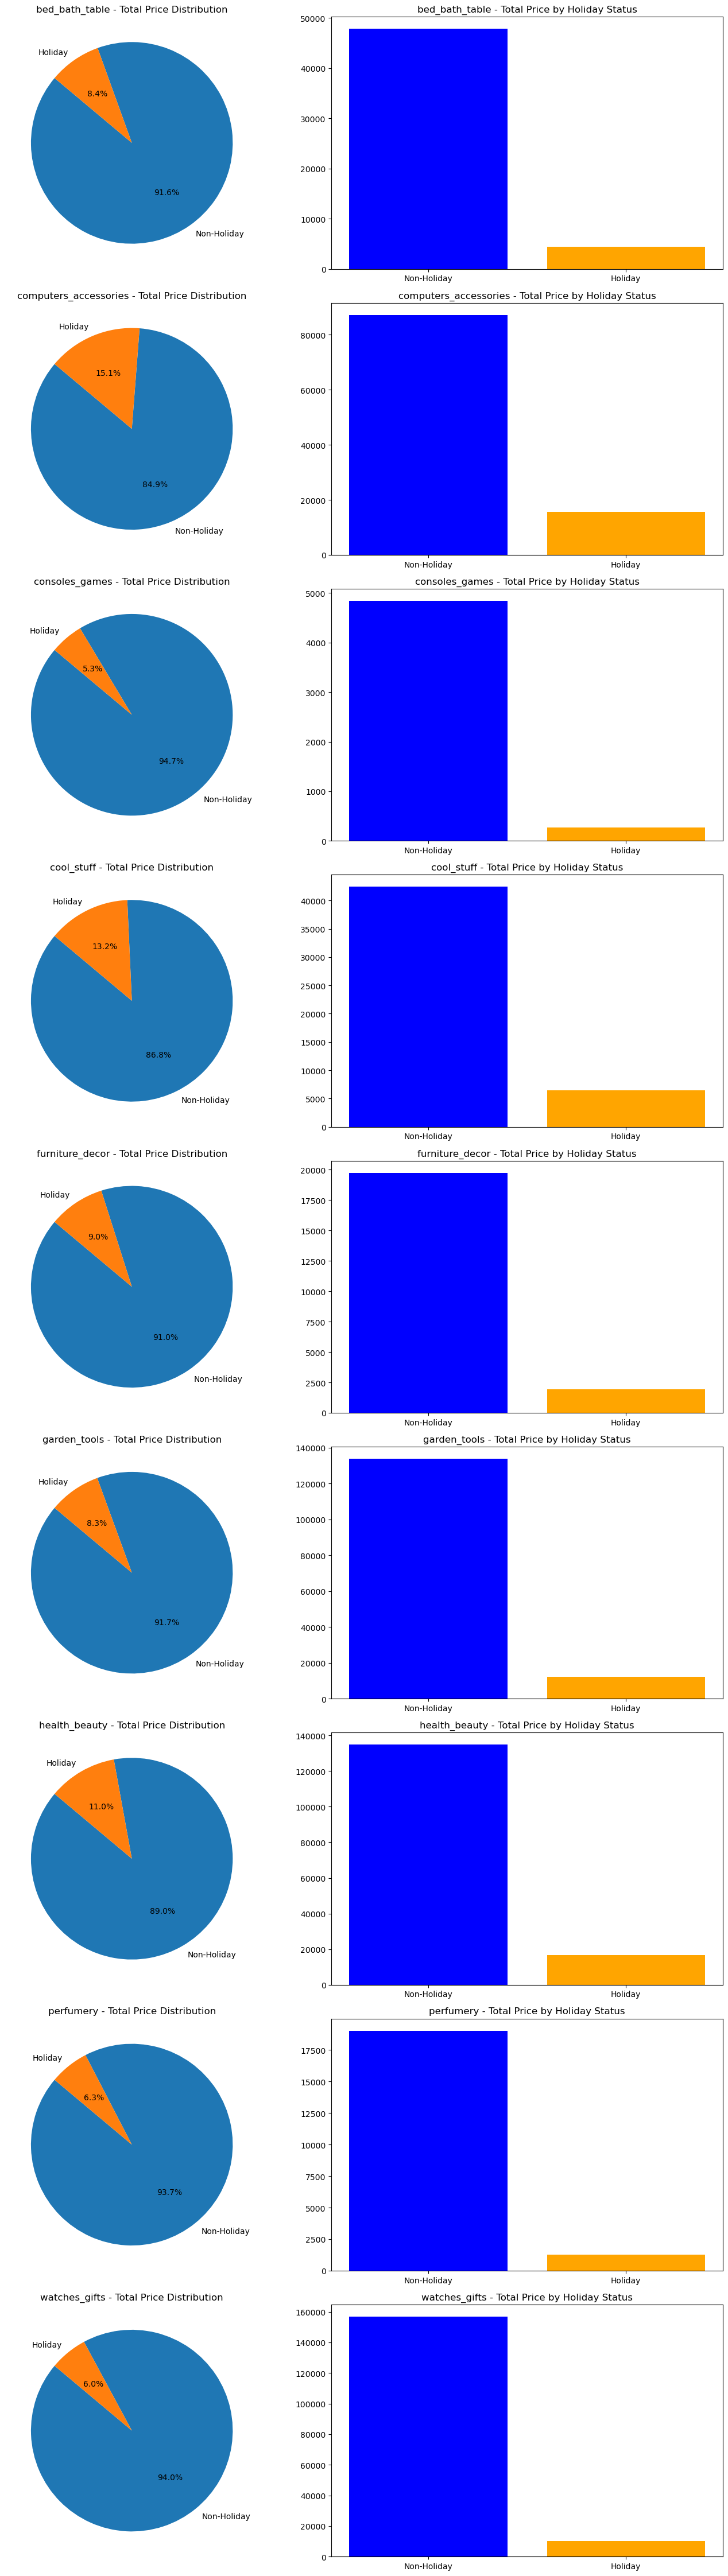

In [43]:
res3 = df_cleaned.groupby(['product_category_name','IsHoliday'])['total_price'].sum().reset_index()
categories = res3['product_category_name'].unique()
fig, axs = plt.subplots(len(categories), 2, figsize=(14, len(categories) * 5))
for i, category in enumerate(categories):
    cat_data = res3[res3['product_category_name'] == category]
    values = cat_data['total_price']
    labels = ['Holiday' if is_holiday == 1 else 'Non-Holiday' for is_holiday in cat_data['IsHoliday']]
    axs[i, 0].pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    axs[i, 0].set_title(f'{category} - Total Price Distribution')
    axs[i, 1].bar(labels, values, color=['blue', 'orange'])
    axs[i, 1].set_title(f'{category} - Total Price by Holiday Status')
plt.tight_layout()
plt.show()

## 6. Demand Elasticity

In [44]:
df_cleaned.head()

product_id product_category_name month_year  qty  total_price  \
0       bed1        bed_bath_table 2017-01-05    1        45.95   
1       bed1        bed_bath_table 2017-01-06    3       137.85   
2       bed1        bed_bath_table 2017-01-07    6       275.70   
3       bed1        bed_bath_table 2017-01-08    4       183.80   
4       bed1        bed_bath_table 2017-01-09    2        91.90   

   freight_price  unit_price  product_name_lenght  product_description_lenght  \
0      15.100000       45.95                   39                         161   
1      12.933333       45.95                   39                         161   
2      14.840000       45.95                   39                         161   
3      14.287500       45.95                   39                         161   
4      15.100000       45.95                   39                         161   

   product_photos_qty  ...        fp1      comp_2  ps2        fp2  comp_3  \
0                   2  ...  15.011897  215.000000  4.4   8.760000   45.95   
1                   2  ...  14.769216  209.000000  4.4  21.322000   45.95   
2                   2  ...  13.993833  205.000000  4.4  22.195932   45.95   
3                   2  ...  14.656757  199.509804  4.4  19.412885   45.95   
4                   2  ...  18.776522  163.398710  4.4  24.324687   45.95   

   ps3        fp3  lag_price  IsWeekend  IsHoliday  
0  4.0  15.100000      45.90      False      False  
1  4.0  12.933333      45.95      False      False  
2  4.0  14.840000      45.95       True      False  
3  4.0  14.287500      45.95       True      False  
4  4.0  15.100000      45.95      False      False  

[5 rows x 32 columns]

In [45]:
df_cleaned['price_change'] = df_cleaned['unit_price'] - df_cleaned['lag_price']
df_cleaned

product_id product_category_name month_year  qty  total_price  \
0         bed1        bed_bath_table 2017-01-05    1        45.95   
1         bed1        bed_bath_table 2017-01-06    3       137.85   
2         bed1        bed_bath_table 2017-01-07    6       275.70   
3         bed1        bed_bath_table 2017-01-08    4       183.80   
4         bed1        bed_bath_table 2017-01-09    2        91.90   
..         ...                   ...        ...  ...          ...   
646   watches1         watches_gifts 2018-01-04    9      1351.20   
647   watches1         watches_gifts 2018-01-05   32      4241.00   
648   watches1         watches_gifts 2018-01-06   15      2073.30   
649   watches1         watches_gifts 2018-01-07    2       310.00   
650   watches1         watches_gifts 2018-01-08   11      1601.06   

     freight_price  unit_price  product_name_lenght  \
0        15.100000   45.950000                   39   
1        12.933333   45.950000                   39   
2        14.840000   45.950000                   39   
3        14.287500   45.950000                   39   
4        15.100000   45.950000                   39   
..             ...         ...                  ...   
646      19.447778  150.133333                   35   
647      15.762187  132.531250                   35   
648      16.108000  138.220000                   35   
649      16.470000  155.000000                   35   
650      21.897273  145.550909                   35   

     product_description_lenght  product_photos_qty  ...      comp_2  ps2  \
0                           161                   2  ...  215.000000  4.4   
1                           161                   2  ...  209.000000  4.4   
2                           161                   2  ...  205.000000  4.4   
3                           161                   2  ...  199.509804  4.4   
4                           161                   2  ...  163.398710  4.4   
..                          ...                 ...  ...         ...  ...   
646                         514                   2  ...  105.000000  4.2   
647                         514                   2  ...  105.000000  4.2   
648                         514                   2  ...  105.000000  4.2   
649                         514                   2  ...  105.000000  4.2   
650                         514                   2  ...  105.000000  4.2   

           fp2      comp_3  ps3        fp3   lag_price  IsWeekend  IsHoliday  \
0     8.760000   45.950000  4.0  15.100000   45.900000      False      False   
1    21.322000   45.950000  4.0  12.933333   45.950000      False      False   
2    22.195932   45.950000  4.0  14.840000   45.950000       True      False   
3    19.412885   45.950000  4.0  14.287500   45.950000       True      False   
4    24.324687   45.950000  4.0  15.100000   45.950000      False      False   
..         ...         ...  ...        ...         ...        ...        ...   
646  13.631429  150.133333  3.8  19.447778  151.878437      False      False   
647  11.377297  132.531250  3.8  15.762187  150.133333      False      False   
648  23.823571  138.220000  3.8  16.108000  132.531250       True      False   
649  24.938750  155.000000  3.8  16.470000  138.220000       True      False   
650  23.385714  145.550909  3.8  21.897273  155.000000      False      False   

     price_change  
0        0.050000  
1        0.000000  
2        0.000000  
3        0.000000  
4        0.000000  
..            ...  
646     -1.745104  
647    -17.602083  
648      5.688750  
649     16.780000  
650     -9.449091  

[637 rows x 33 columns]

In [46]:
res4 = df_cleaned.groupby(['product_id','month'])['price_change'].mean().reset_index()
res4

product_id  month  price_change
0         bed1      1      0.000000
1         bed1      2      0.000000
2         bed1      3      0.000000
3         bed1      4      0.000000
4         bed1      5      0.025000
..         ...    ...           ...
520   watches8      5     -5.175641
521   watches8      6      7.466667
522   watches8      7      2.279762
523   watches8      8      0.802597
524   watches8     10      0.050000

[525 rows x 3 columns]

In [47]:
df_cleaned['quarter'] = pd.cut(df_cleaned['month'], 
                               bins=[0, 3, 6, 9, 12], 
                               labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Confirm that the quarter column has been added
df_cleaned[['month', 'quarter']].head()

month quarter
0      5      Q2
1      6      Q2
2      7      Q3
3      8      Q3
4      9      Q3

In [48]:
res5 = df_cleaned.groupby(['product_category_name','quarter']).agg({'qty':'sum', 'price_change' : 'mean'})
res5.head()

qty  price_change
product_category_name quarter                   
bed_bath_table        Q1       204     -0.467017
                      Q2       191     -1.176471
                      Q3       117     -0.554167
                      Q4       202     -0.605980
computers_accessories Q1       420     -5.898411

In [49]:
res5['qty_prev_month'] = res5['qty'].shift(1)
res5['price_prev_month'] = res5['price_change'].shift(1)
res5.head()

qty  price_change  qty_prev_month  \
product_category_name quarter                                      
bed_bath_table        Q1       204     -0.467017             NaN   
                      Q2       191     -1.176471           204.0   
                      Q3       117     -0.554167           191.0   
                      Q4       202     -0.605980           117.0   
computers_accessories Q1       420     -5.898411           202.0   

                               price_prev_month  
product_category_name quarter                    
bed_bath_table        Q1                    NaN  
                      Q2              -0.467017  
                      Q3              -1.176471  
                      Q4              -0.554167  
computers_accessories Q1              -0.605980

In [50]:
res5 = res5.fillna(0.0)

In [51]:
def price_percent_change(price_diff,price_prev_month):
    if price_prev_month == 0:
        return 0
    else:
        return (price_diff/price_prev_month) * 100

In [52]:
def qty_percent_change(qty_diff,qty_prev_month):
    if qty_prev_month == 0:
        return 0
    else:
        return (qty_diff/qty_prev_month) * 100

In [53]:
def elastic_demand(price_percent_change,qty_percent_change):
    if price_percent_change == 0:
        return 0
    else:
        return qty_percent_change/price_percent_change

In [54]:
type(res5)

pandas.core.frame.DataFrame

In [55]:
res5['price_diff'] = res5['price_change'] - res5['price_prev_month']
#res5['price_percent_change'] = res5[['price_diff','price_prev_month']].apply(price_percent_change,axis = 1)
res5['qty_diff'] = res5['qty'] - res5['qty_prev_month']
#res5['qty_percent_change'] = res5[['qty_diff','qty_previous_month']].apply(qty_percent_change)

In [56]:
res5['price_percent_change'] = res5.apply(lambda row: price_percent_change(row['price_diff'], row['price_prev_month']), axis=1)

In [57]:
res5['qty_percent_change'] = res5.apply(lambda row : qty_percent_change(row['qty_diff'],row['qty_prev_month']),axis = 1)

In [58]:
res5['elasticity'] = res5.apply(lambda row : elastic_demand(row['price_percent_change'],row['qty_percent_change']),axis = 1)

In [59]:
res5.head()

qty  price_change  qty_prev_month  \
product_category_name quarter                                      
bed_bath_table        Q1       204     -0.467017             0.0   
                      Q2       191     -1.176471           204.0   
                      Q3       117     -0.554167           191.0   
                      Q4       202     -0.605980           117.0   
computers_accessories Q1       420     -5.898411           202.0   

                               price_prev_month  price_diff  qty_diff  \
product_category_name quarter                                           
bed_bath_table        Q1               0.000000   -0.467017     204.0   
                      Q2              -0.467017   -0.709454     -13.0   
                      Q3              -1.176471    0.622304     -74.0   
                      Q4              -0.554167   -0.051814      85.0   
computers_accessories Q1              -0.605980   -5.292431     218.0   

                               price_percent_change  qty_percent_change  \
product_category_name quarter                                             
bed_bath_table        Q1                   0.000000            0.000000   
                      Q2                 151.911831           -6.372549   
                      Q3                 -52.895833          -38.743455   
                      Q4                   9.349845           72.649573   
computers_accessories Q1                 873.366697          107.920792   

                               elasticity  
product_category_name quarter              
bed_bath_table        Q1         0.000000  
                      Q2        -0.041949  
                      Q3         0.732448  
                      Q4         7.770136  
computers_accessories Q1         0.123569

In [60]:
#sorted = res5.sort_values(by=['product_id','elasticity'], ascending = [True,False])
#sorted

In [61]:
res5.isna().sum()

qty                     0
price_change            0
qty_prev_month          0
price_prev_month        0
price_diff              0
qty_diff                0
price_percent_change    0
qty_percent_change      0
elasticity              0
dtype: int64

In [62]:
outliers = res5[(res5['elasticity']  <-1 ) | (res5['elasticity']  >1 )]
outliers

qty  price_change  qty_prev_month  \
product_category_name quarter                                      
bed_bath_table        Q4       202     -0.605980           117.0   
consoles_games        Q2        18      1.289286            29.0   
                      Q3        68      0.014286            18.0   
cool_stuff            Q1       196      1.133288            96.0   
furniture_decor       Q4       108     -0.180714           101.0   
watches_gifts         Q1       311     -7.351778            83.0   
                      Q3       278     -1.405963           363.0   

                               price_prev_month  price_diff  qty_diff  \
product_category_name quarter                                           
bed_bath_table        Q4              -0.554167   -0.051814      85.0   
consoles_games        Q2               1.658571   -0.369286     -11.0   
                      Q3               1.289286   -1.275000      50.0   
cool_stuff            Q1               1.248571   -0.115283     100.0   
furniture_decor       Q4              -0.180952    0.000238       7.0   
watches_gifts         Q1              -4.083333   -3.268444     228.0   
                      Q3              -1.625875    0.219912     -85.0   

                               price_percent_change  qty_percent_change  \
product_category_name quarter                                             
bed_bath_table        Q4                   9.349845           72.649573   
consoles_games        Q2                 -22.265288          -37.931034   
                      Q3                 -98.891967          277.777778   
cool_stuff            Q1                  -9.233226          104.166667   
furniture_decor       Q4                  -0.131580            6.930693   
watches_gifts         Q1                  80.043532          274.698795   
                      Q3                 -13.525768          -23.415978   

                               elasticity  
product_category_name quarter              
bed_bath_table        Q4         7.770136  
consoles_games        Q2         1.703595  
                      Q3        -2.808901  
cool_stuff            Q1       -11.281719  
furniture_decor       Q4       -52.672807  
watches_gifts         Q1         3.431867  
                      Q3         1.731212

In [63]:
# elastic demand
res5['segment'] = 'Inelastic'
res5.loc[(res5['elasticity'] < -1) | (res5['elasticity'] > 1), 'segment'] = 'Elastic'

# unitary Elasticity
res5.loc[res5['elasticity'].between(0.9, 1.1), 'segment'] = 'Unitary'

# positive Elasticity
res5.loc[res5['elasticity'] > 0, 'segment'] = 'Positive Elasticity'

# negative Elasticity (Demand drops when price increases)
res5.loc[res5['elasticity'] < 0, 'segment'] = 'Negative Elasticity'




res5.head()

qty  price_change  qty_prev_month  \
product_category_name quarter                                      
bed_bath_table        Q1       204     -0.467017             0.0   
                      Q2       191     -1.176471           204.0   
                      Q3       117     -0.554167           191.0   
                      Q4       202     -0.605980           117.0   
computers_accessories Q1       420     -5.898411           202.0   

                               price_prev_month  price_diff  qty_diff  \
product_category_name quarter                                           
bed_bath_table        Q1               0.000000   -0.467017     204.0   
                      Q2              -0.467017   -0.709454     -13.0   
                      Q3              -1.176471    0.622304     -74.0   
                      Q4              -0.554167   -0.051814      85.0   
computers_accessories Q1              -0.605980   -5.292431     218.0   

                               price_percent_change  qty_percent_change  \
product_category_name quarter                                             
bed_bath_table        Q1                   0.000000            0.000000   
                      Q2                 151.911831           -6.372549   
                      Q3                 -52.895833          -38.743455   
                      Q4                   9.349845           72.649573   
computers_accessories Q1                 873.366697          107.920792   

                               elasticity              segment  
product_category_name quarter                                   
bed_bath_table        Q1         0.000000            Inelastic  
                      Q2        -0.041949  Negative Elasticity  
                      Q3         0.732448  Positive Elasticity  
                      Q4         7.770136  Positive Elasticity  
computers_accessories Q1         0.123569  Positive Elasticity

**Average elasticity by quarter**

In [64]:
res5.head()

qty  price_change  qty_prev_month  \
product_category_name quarter                                      
bed_bath_table        Q1       204     -0.467017             0.0   
                      Q2       191     -1.176471           204.0   
                      Q3       117     -0.554167           191.0   
                      Q4       202     -0.605980           117.0   
computers_accessories Q1       420     -5.898411           202.0   

                               price_prev_month  price_diff  qty_diff  \
product_category_name quarter                                           
bed_bath_table        Q1               0.000000   -0.467017     204.0   
                      Q2              -0.467017   -0.709454     -13.0   
                      Q3              -1.176471    0.622304     -74.0   
                      Q4              -0.554167   -0.051814      85.0   
computers_accessories Q1              -0.605980   -5.292431     218.0   

                               price_percent_change  qty_percent_change  \
product_category_name quarter                                             
bed_bath_table        Q1                   0.000000            0.000000   
                      Q2                 151.911831           -6.372549   
                      Q3                 -52.895833          -38.743455   
                      Q4                   9.349845           72.649573   
computers_accessories Q1                 873.366697          107.920792   

                               elasticity              segment  
product_category_name quarter                                   
bed_bath_table        Q1         0.000000            Inelastic  
                      Q2        -0.041949  Negative Elasticity  
                      Q3         0.732448  Positive Elasticity  
                      Q4         7.770136  Positive Elasticity  
computers_accessories Q1         0.123569  Positive Elasticity

In [65]:
avg_elasticity = res5.groupby(['quarter'])['elasticity'].mean().reset_index()


avg_elasticity['segment'] = 'Inelastic'
avg_elasticity.loc[(avg_elasticity['elasticity'] < -1) | (avg_elasticity['elasticity'] > 1), 'segment'] = 'Elastic'

# Unitary Elasticity
avg_elasticity.loc[avg_elasticity['elasticity'].between(0.9, 1.1), 'segment'] = 'Unitary'

# Positive Elasticity
avg_elasticity.loc[avg_elasticity['elasticity'] > 0, 'segment'] = 'Positive Elasticity'

# Negative Elasticity (Demand drops when price increases)
avg_elasticity.loc[avg_elasticity['elasticity'] < 0, 'segment'] = 'Negative Elasticity'

avg_elasticity

quarter  elasticity              segment
0      Q1   -0.927177  Negative Elasticity
1      Q2    0.296961  Positive Elasticity
2      Q3   -0.014563  Negative Elasticity
3      Q4   -4.881885  Negative Elasticity

**Cross Category Comparison**

In [66]:
prod_elasticity = res5.groupby(['product_category_name'])['elasticity'].mean().reset_index()


In [67]:
prod_elasticity['segment'] = prod_elasticity['elasticity'].apply(lambda x : 'Elastic' if x > 1  else 'Inelastic')
prod_elasticity

product_category_name  elasticity    segment
0         bed_bath_table    2.115159    Elastic
1  computers_accessories    0.459553  Inelastic
2         consoles_games   -0.236279  Inelastic
3             cool_stuff   -2.697684  Inelastic
4        furniture_decor  -13.305230  Inelastic
5           garden_tools   -0.178610  Inelastic
6          health_beauty    0.132657  Inelastic
7              perfumery   -0.034771  Inelastic
8          watches_gifts    1.310212    Elastic

**Revenue Elasticity**

In [68]:
revenue_df = df_cleaned.groupby(['product_category_name','quarter'])['total_price'].sum().reset_index()
revenue_df.head()

product_category_name quarter  total_price
0         bed_bath_table      Q1     13727.16
1         bed_bath_table      Q2     15409.55
2         bed_bath_table      Q3      8823.34
3         bed_bath_table      Q4     14239.01
4  computers_accessories      Q1     42457.19

In [127]:
revenue_df

product_category_name quarter  total_price
0          bed_bath_table      Q1     13727.16
1          bed_bath_table      Q2     15409.55
2          bed_bath_table      Q3      8823.34
3          bed_bath_table      Q4     14239.01
4   computers_accessories      Q1     42457.19
5   computers_accessories      Q2     27110.40
6   computers_accessories      Q3     16575.44
7   computers_accessories      Q4     16661.22
8          consoles_games      Q1       890.40
9          consoles_games      Q2       631.60
10         consoles_games      Q3      1369.50
11         consoles_games      Q4      2223.20
12             cool_stuff      Q1     15189.87
13             cool_stuff      Q2     16936.96
14             cool_stuff      Q3      9914.60
15             cool_stuff      Q4      6823.43
16        furniture_decor      Q1      6043.40
17        furniture_decor      Q2      5561.20
18        furniture_decor      Q3      5713.70
19        furniture_decor      Q4      4392.26
20           garden_tools      Q1     38386.35
21           garden_tools      Q2     32515.79
22           garden_tools      Q3     33488.10
23           garden_tools      Q4     41601.01
24          health_beauty      Q1     31107.72
25          health_beauty      Q2     36837.39
26          health_beauty      Q3     48662.10
27          health_beauty      Q4     34996.66
28              perfumery      Q1      3979.72
29              perfumery      Q2      4978.54
30              perfumery      Q3      5232.47
31              perfumery      Q4      6121.79
32          watches_gifts      Q1     47077.49
33          watches_gifts      Q2     47174.38
34          watches_gifts      Q3     39302.84
35          watches_gifts      Q4     33351.00

## 7. Summary table

In [69]:
df_cleaned['comp1price_dff'] = df_cleaned['unit_price'] - df_cleaned['comp_1']
df_cleaned['comp2price_dff'] = df_cleaned['unit_price'] - df_cleaned['comp_2']
df_cleaned['comp3price_dff'] = df_cleaned['unit_price'] - df_cleaned['comp_3']

In [70]:
compdiff = df_cleaned.groupby(['product_category_name','quarter'])[['comp1price_dff', 'comp2price_dff', 'comp3price_dff']].mean().reset_index()

In [71]:
compdiff['price_overall_diff'] = compdiff[['comp1price_dff', 'comp2price_dff', 'comp3price_dff']].mean(axis=1)

In [72]:
compdiff.head()

product_category_name quarter  comp1price_dff  comp2price_dff  \
0         bed_bath_table      Q1      -17.152143        0.000000   
1         bed_bath_table      Q2       -3.635226      -19.535294   
2         bed_bath_table      Q3      -18.060000      -51.097252   
3         bed_bath_table      Q4      -20.453204        0.000000   
4  computers_accessories      Q1      -37.015132      -38.811666   

   comp3price_dff  price_overall_diff  
0       23.056429            1.968095  
1       36.970566            4.600015  
2       21.590278          -15.855658  
3       26.818935            2.121911  
4       17.126033          -19.566922

In [73]:
df_cleaned['fr1price_dff'] = df_cleaned['freight_price'] - df_cleaned['fp1']
df_cleaned['fr2price_dff'] = df_cleaned['freight_price'] - df_cleaned['fp2']
df_cleaned['fr3price_dff'] = df_cleaned['freight_price'] - df_cleaned['fp3']

In [74]:
freight_costs = df_cleaned.groupby(['product_category_name','quarter'])[['fr1price_dff', 'fr2price_dff', 'fr3price_dff']].mean().reset_index()
freight_costs['freight_overall_diff'] = freight_costs[['fr1price_dff', 'fr2price_dff', 'fr3price_dff']].mean(axis=1)
freight_costs.head()

product_category_name quarter  fr1price_dff  fr2price_dff  fr3price_dff  \
0         bed_bath_table      Q1     -2.911669      0.000000      0.468186   
1         bed_bath_table      Q2     -1.902804     -0.120510      1.652362   
2         bed_bath_table      Q3     -0.772334     -2.667525     -0.093227   
3         bed_bath_table      Q4     -2.399089      0.000000      1.134827   
4  computers_accessories      Q1    -18.055125     -4.140406      4.585119   

   freight_overall_diff  
0             -0.814494  
1             -0.123650  
2             -1.177696  
3             -0.421420  
4             -5.870137

In [75]:
df_cleaned['quarter'] = pd.cut(df_cleaned['month'], 
                               bins=[0, 3, 6, 9, 12], 
                               labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Confirm that the quarter column has been added
df_cleaned[['month', 'quarter']].head()

month quarter
0      5      Q2
1      6      Q2
2      7      Q3
3      8      Q3
4      9      Q3

In [76]:
quarterly_sales_cat = df_cleaned.groupby(['product_category_name', 'quarter'])['total_price'].sum().reset_index()
avg_sales_per_quarter = quarterly_sales_cat.groupby('product_category_name')['total_price'].mean().reset_index()
avg_sales_per_quarter.columns = ['product_category_name', 'avg_sales']
quarterly_sales_cat = pd.merge(quarterly_sales_cat, avg_sales_per_quarter, on='product_category_name')

In [77]:
quarterly_sales_cat['seasonality_index'] = quarterly_sales_cat['total_price'] / quarterly_sales_cat['avg_sales']

In [78]:
df_cleaned[df_cleaned['product_category_name'] == 'bed_bath_table']['total_price'].mean()

949.0738181818183

In [79]:
quarterly_sales_cat.head()

product_category_name quarter  total_price   avg_sales  seasonality_index
0         bed_bath_table      Q1     13727.16  13049.7650           1.051909
1         bed_bath_table      Q2     15409.55  13049.7650           1.180830
2         bed_bath_table      Q3      8823.34  13049.7650           0.676130
3         bed_bath_table      Q4     14239.01  13049.7650           1.091132
4  computers_accessories      Q1     42457.19  25701.0625           1.651962

In [80]:
res6 = quarterly_sales_cat[quarterly_sales_cat['product_category_name'] == 'cool_stuff']
res6

product_category_name quarter  total_price  avg_sales  seasonality_index
12            cool_stuff      Q1     15189.87  12216.215           1.243419
13            cool_stuff      Q2     16936.96  12216.215           1.386433
14            cool_stuff      Q3      9914.60  12216.215           0.811593
15            cool_stuff      Q4      6823.43  12216.215           0.558555

In [81]:
category_res = pd.merge(res5,quarterly_sales_cat, on=['product_category_name','quarter'],how = 'inner')
category_res.head()

product_category_name quarter  qty  price_change  qty_prev_month  \
0         bed_bath_table      Q1  204     -0.467017             0.0   
1         bed_bath_table      Q2  191     -1.176471           204.0   
2         bed_bath_table      Q3  117     -0.554167           191.0   
3         bed_bath_table      Q4  202     -0.605980           117.0   
4  computers_accessories      Q1  420     -5.898411           202.0   

   price_prev_month  price_diff  qty_diff  price_percent_change  \
0          0.000000   -0.467017     204.0              0.000000   
1         -0.467017   -0.709454     -13.0            151.911831   
2         -1.176471    0.622304     -74.0            -52.895833   
3         -0.554167   -0.051814      85.0              9.349845   
4         -0.605980   -5.292431     218.0            873.366697   

   qty_percent_change  elasticity              segment  total_price  \
0            0.000000    0.000000            Inelastic     13727.16   
1           -6.372549   -0.041949  Negative Elasticity     15409.55   
2          -38.743455    0.732448  Positive Elasticity      8823.34   
3           72.649573    7.770136  Positive Elasticity     14239.01   
4          107.920792    0.123569  Positive Elasticity     42457.19   

    avg_sales  seasonality_index  
0  13049.7650           1.051909  
1  13049.7650           1.180830  
2  13049.7650           0.676130  
3  13049.7650           1.091132  
4  25701.0625           1.651962

In [82]:
category_res = pd.merge(category_res,compdiff,on=['product_category_name','quarter'],how = 'inner')
category_res.head()

product_category_name quarter  qty  price_change  qty_prev_month  \
0         bed_bath_table      Q1  204     -0.467017             0.0   
1         bed_bath_table      Q2  191     -1.176471           204.0   
2         bed_bath_table      Q3  117     -0.554167           191.0   
3         bed_bath_table      Q4  202     -0.605980           117.0   
4  computers_accessories      Q1  420     -5.898411           202.0   

   price_prev_month  price_diff  qty_diff  price_percent_change  \
0          0.000000   -0.467017     204.0              0.000000   
1         -0.467017   -0.709454     -13.0            151.911831   
2         -1.176471    0.622304     -74.0            -52.895833   
3         -0.554167   -0.051814      85.0              9.349845   
4         -0.605980   -5.292431     218.0            873.366697   

   qty_percent_change  elasticity              segment  total_price  \
0            0.000000    0.000000            Inelastic     13727.16   
1           -6.372549   -0.041949  Negative Elasticity     15409.55   
2          -38.743455    0.732448  Positive Elasticity      8823.34   
3           72.649573    7.770136  Positive Elasticity     14239.01   
4          107.920792    0.123569  Positive Elasticity     42457.19   

    avg_sales  seasonality_index  comp1price_dff  comp2price_dff  \
0  13049.7650           1.051909      -17.152143        0.000000   
1  13049.7650           1.180830       -3.635226      -19.535294   
2  13049.7650           0.676130      -18.060000      -51.097252   
3  13049.7650           1.091132      -20.453204        0.000000   
4  25701.0625           1.651962      -37.015132      -38.811666   

   comp3price_dff  price_overall_diff  
0       23.056429            1.968095  
1       36.970566            4.600015  
2       21.590278          -15.855658  
3       26.818935            2.121911  
4       17.126033          -19.566922

In [83]:
category_res = pd.merge(category_res,freight_costs,on=['product_category_name','quarter'],how = 'inner')

In [84]:
category_res.columns

Index(['product_category_name', 'quarter', 'qty', 'price_change',
       'qty_prev_month', 'price_prev_month', 'price_diff', 'qty_diff',
       'price_percent_change', 'qty_percent_change', 'elasticity', 'segment',
       'total_price', 'avg_sales', 'seasonality_index', 'comp1price_dff',
       'comp2price_dff', 'comp3price_dff', 'price_overall_diff',
       'fr1price_dff', 'fr2price_dff', 'fr3price_dff', 'freight_overall_diff'],
      dtype='object')

In [85]:
final_res = category_res[['product_category_name', 'quarter','elasticity', 'segment','seasonality_index','price_overall_diff','freight_overall_diff']]
final_res.head()

product_category_name quarter  elasticity              segment  \
0         bed_bath_table      Q1    0.000000            Inelastic   
1         bed_bath_table      Q2   -0.041949  Negative Elasticity   
2         bed_bath_table      Q3    0.732448  Positive Elasticity   
3         bed_bath_table      Q4    7.770136  Positive Elasticity   
4  computers_accessories      Q1    0.123569  Positive Elasticity   

   seasonality_index  price_overall_diff  freight_overall_diff  
0           1.051909            1.968095             -0.814494  
1           1.180830            4.600015             -0.123650  
2           0.676130          -15.855658             -1.177696  
3           1.091132            2.121911             -0.421420  
4           1.651962          -19.566922             -5.870137

In [128]:
print(final_res)

    product_category_name quarter  elasticity              segment  \
0          bed_bath_table      Q1    0.000000            Inelastic   
1          bed_bath_table      Q2   -0.041949  Negative Elasticity   
2          bed_bath_table      Q3    0.732448  Positive Elasticity   
3          bed_bath_table      Q4    7.770136  Positive Elasticity   
4   computers_accessories      Q1    0.123569  Positive Elasticity   
5   computers_accessories      Q2    0.857170  Positive Elasticity   
6   computers_accessories      Q3    0.672779  Positive Elasticity   
7   computers_accessories      Q4    0.184693  Positive Elasticity   
8          consoles_games      Q1    0.155425  Positive Elasticity   
9          consoles_games      Q2    1.703595  Positive Elasticity   
10         consoles_games      Q3   -2.808901  Negative Elasticity   
11         consoles_games      Q4    0.004766  Positive Elasticity   
12             cool_stuff      Q1  -11.281719  Negative Elasticity   
13             cool_

## 8. Price Optimization Models

In [86]:
df_cleaned.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'freight_price', 'unit_price', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3', 'lag_price', 'IsWeekend', 'IsHoliday',
       'price_change', 'quarter', 'comp1price_dff', 'comp2price_dff',
       'comp3price_dff', 'fr1price_dff', 'fr2price_dff', 'fr3price_dff'],
      dtype='object')

In [87]:
#creating dataframes by product category
prod_cat = df_cleaned['product_category_name'].unique()
prod_cat

array(['bed_bath_table', 'computers_accessories', 'consoles_games',
       'cool_stuff', 'furniture_decor', 'garden_tools', 'health_beauty',
       'perfumery', 'watches_gifts'], dtype=object)

In [88]:
df_dict = {}
for product in prod_cat:
    prod_df = df_cleaned[df_cleaned['product_category_name'] == product]
    df_dict[product] = prod_df

In [89]:
df_dict['bed_bath_table'].head()

product_id product_category_name month_year  qty  total_price  \
0       bed1        bed_bath_table 2017-01-05    1        45.95   
1       bed1        bed_bath_table 2017-01-06    3       137.85   
2       bed1        bed_bath_table 2017-01-07    6       275.70   
3       bed1        bed_bath_table 2017-01-08    4       183.80   
4       bed1        bed_bath_table 2017-01-09    2        91.90   

   freight_price  unit_price  product_name_lenght  product_description_lenght  \
0      15.100000       45.95                   39                         161   
1      12.933333       45.95                   39                         161   
2      14.840000       45.95                   39                         161   
3      14.287500       45.95                   39                         161   
4      15.100000       45.95                   39                         161   

   product_photos_qty  ...  IsWeekend  IsHoliday  price_change  quarter  \
0                   2  ...      False      False          0.05       Q2   
1                   2  ...      False      False          0.00       Q2   
2                   2  ...       True      False          0.00       Q3   
3                   2  ...       True      False          0.00       Q3   
4                   2  ...      False      False          0.00       Q3   

   comp1price_dff  comp2price_dff  comp3price_dff  fr1price_dff  fr2price_dff  \
0          -43.95     -169.050000             0.0      0.088103      6.340000   
1          -43.95     -163.050000             0.0     -1.835882     -8.388667   
2          -43.95     -159.050000             0.0      0.846167     -7.355932   
3          -43.95     -153.559804             0.0     -0.369257     -5.125385   
4          -43.95     -117.448710             0.0     -3.676522     -9.224687   

   fr3price_dff  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  

[5 rows x 40 columns]

### 8.1 Cost plus pricing model

In [90]:
df_dict.keys()

dict_keys(['bed_bath_table', 'computers_accessories', 'consoles_games', 'cool_stuff', 'furniture_decor', 'garden_tools', 'health_beauty', 'perfumery', 'watches_gifts'])

In [91]:
bed_df = df_dict['bed_bath_table']

In [92]:
bed_df.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'freight_price', 'unit_price', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3', 'lag_price', 'IsWeekend', 'IsHoliday',
       'price_change', 'quarter', 'comp1price_dff', 'comp2price_dff',
       'comp3price_dff', 'fr1price_dff', 'fr2price_dff', 'fr3price_dff'],
      dtype='object')

In [93]:
res = bed_df.groupby(['product_id','quarter'])['unit_price'].mean().reset_index()
res.head()

product_id quarter  unit_price
0       bed1      Q1   39.990000
1       bed1      Q2   42.374000
2       bed1      Q3   43.416000
3       bed1      Q4   42.157273
4       bed2      Q1   88.100000

In [94]:
def cost_plus_pricing(df):
    low_markup = 0.0125 # for cheaper items
    high_markup = 0.0150 # for costlier items

    df['avg_prod_cost'] =  df.groupby(['product_id','quarter'])['unit_price'].transform('mean')

    df['orig_ext_final_price'] = df['total_price'] + df['freight_price']

    df['markup'] = df['avg_prod_cost'].apply(lambda x : high_markup  if x > 50 else low_markup)

    df['calc_final_price'] = (df['total_price'] + df['freight_price']) * (1 + df['markup'])

    return df

In [95]:
cost_plus_df = cost_plus_pricing(bed_df)
cost_plus_df.head()

product_id product_category_name month_year  qty  total_price  \
0       bed1        bed_bath_table 2017-01-05    1        45.95   
1       bed1        bed_bath_table 2017-01-06    3       137.85   
2       bed1        bed_bath_table 2017-01-07    6       275.70   
3       bed1        bed_bath_table 2017-01-08    4       183.80   
4       bed1        bed_bath_table 2017-01-09    2        91.90   

   freight_price  unit_price  product_name_lenght  product_description_lenght  \
0      15.100000       45.95                   39                         161   
1      12.933333       45.95                   39                         161   
2      14.840000       45.95                   39                         161   
3      14.287500       45.95                   39                         161   
4      15.100000       45.95                   39                         161   

   product_photos_qty  ...  comp1price_dff  comp2price_dff  comp3price_dff  \
0                   2  ...          -43.95     -169.050000             0.0   
1                   2  ...          -43.95     -163.050000             0.0   
2                   2  ...          -43.95     -159.050000             0.0   
3                   2  ...          -43.95     -153.559804             0.0   
4                   2  ...          -43.95     -117.448710             0.0   

   fr1price_dff  fr2price_dff  fr3price_dff  avg_prod_cost  \
0      0.088103      6.340000           0.0         42.374   
1     -1.835882     -8.388667           0.0         42.374   
2      0.846167     -7.355932           0.0         43.416   
3     -0.369257     -5.125385           0.0         43.416   
4     -3.676522     -9.224687           0.0         43.416   

   orig_ext_final_price  markup  calc_final_price  
0             61.050000  0.0125         61.813125  
1            150.783333  0.0125        152.668125  
2            290.540000  0.0125        294.171750  
3            198.087500  0.0125        200.563594  
4            107.000000  0.0125        108.337500  

[5 rows x 44 columns]

In [96]:
cost_plus_df.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'freight_price', 'unit_price', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3', 'lag_price', 'IsWeekend', 'IsHoliday',
       'price_change', 'quarter', 'comp1price_dff', 'comp2price_dff',
       'comp3price_dff', 'fr1price_dff', 'fr2price_dff', 'fr3price_dff',
       'avg_prod_cost', 'orig_ext_final_price', 'markup', 'calc_final_price'],
      dtype='object')

In [97]:
rev_inc_df = cost_plus_df.groupby(['product_category_name','product_id','quarter']).agg({'orig_ext_final_price' : 'sum', 'calc_final_price' :'sum'}).reset_index()
rev_inc_df['rev_inc_percent'] = (rev_inc_df['calc_final_price'] - rev_inc_df['orig_ext_final_price'])/rev_inc_df['calc_final_price'] * 100

In [98]:
rev_inc_df

product_category_name product_id quarter  orig_ext_final_price  \
0         bed_bath_table       bed1      Q1           2206.205482   
1         bed_bath_table       bed1      Q2           1729.953803   
2         bed_bath_table       bed1      Q3           1266.218750   
3         bed_bath_table       bed1      Q4            869.802727   
4         bed_bath_table       bed2      Q1           7109.247701   
5         bed_bath_table       bed2      Q2           7647.236037   
6         bed_bath_table       bed2      Q3           6763.940993   
7         bed_bath_table       bed2      Q4           6505.564476   
8         bed_bath_table       bed3      Q1           2600.635221   
9         bed_bath_table       bed3      Q2           3283.970079   
10        bed_bath_table       bed3      Q3            875.857778   
11        bed_bath_table       bed3      Q4           3716.812971   
12        bed_bath_table       bed4      Q1           2031.280855   
13        bed_bath_table       bed4      Q2            666.476786   
14        bed_bath_table       bed4      Q3            120.490000   
15        bed_bath_table       bed4      Q4           3345.098664   
16        bed_bath_table       bed5      Q1              0.000000   
17        bed_bath_table       bed5      Q2           2335.082000   
18        bed_bath_table       bed5      Q3              0.000000   
19        bed_bath_table       bed5      Q4              0.000000   

    calc_final_price  rev_inc_percent  
0        2233.783050         1.234568  
1        1751.578226         1.234568  
2        1282.046484         1.234568  
3         880.675261         1.234568  
4        7215.886416         1.477833  
5        7761.944577         1.477833  
6        6865.400108         1.477833  
7        6603.147943         1.477833  
8        2639.644750         1.477833  
9        3333.229631         1.477833  
10        888.995644         1.477833  
11       3772.565165         1.477833  
12       2056.671866         1.234568  
13        674.807746         1.234568  
14        121.996125         1.234568  
15       3386.912397         1.234568  
16          0.000000              NaN  
17       2370.108230         1.477833  
18          0.000000              NaN  
19          0.000000              NaN

### 8.2 Competitor Pricing Model

In [99]:
df_cleaned.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'freight_price', 'unit_price', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3', 'lag_price', 'IsWeekend', 'IsHoliday',
       'price_change', 'quarter', 'comp1price_dff', 'comp2price_dff',
       'comp3price_dff', 'fr1price_dff', 'fr2price_dff', 'fr3price_dff'],
      dtype='object')

In [100]:
df_comp = df_cleaned.copy()


In [101]:
df_comp['price_diff_1']  = df_comp['unit_price'] - df_comp['comp_1']
df_comp['price_diff_2']  = df_comp['unit_price'] - df_comp['comp_2']
df_comp['price_diff_3']  = df_comp['unit_price'] - df_comp['comp_3']

In [102]:
df_cleaned.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'freight_price', 'unit_price', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month',
       'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2',
       'comp_3', 'ps3', 'fp3', 'lag_price', 'IsWeekend', 'IsHoliday',
       'price_change', 'quarter', 'comp1price_dff', 'comp2price_dff',
       'comp3price_dff', 'fr1price_dff', 'fr2price_dff', 'fr3price_dff'],
      dtype='object')

In [103]:
df_cleaned['product_category_name'].unique()

array(['bed_bath_table', 'computers_accessories', 'consoles_games',
       'cool_stuff', 'furniture_decor', 'garden_tools', 'health_beauty',
       'perfumery', 'watches_gifts'], dtype=object)

In [104]:
df_comp = df_cleaned[(df_cleaned['product_category_name'] == 'computers_accessories') | (df_cleaned['product_category_name'] == 'cool_stuff')]

In [105]:
df_comp.head()

product_id  product_category_name month_year  qty  total_price  \
150  computers5  computers_accessories 2017-01-10    1       167.00   
151  computers5  computers_accessories 2017-01-12    2       239.80   
152  computers5  computers_accessories 2018-01-01   57      5453.96   
153  computers5  computers_accessories 2018-01-02   45      3465.80   
154  computers5  computers_accessories 2018-01-03    6       528.00   

     freight_price  unit_price  product_name_lenght  \
150      14.920000  167.000000                   33   
151      13.440000  119.900000                   33   
152      12.239123   93.094894                   33   
153      11.513111   77.155000                   33   
154      17.553333   88.000000                   33   

     product_description_lenght  product_photos_qty  ...  IsWeekend  \
150                         300                   1  ...      False   
151                         300                   1  ...      False   
152                         300                   1  ...      False   
153                         300                   1  ...      False   
154                         300                   1  ...      False   

     IsHoliday  price_change  quarter  comp1price_dff  comp2price_dff  \
150      False      0.050000       Q4       12.304118        0.000000   
151      False      0.050000       Q4      -30.090000        0.000000   
152       True    -26.805106       Q1      -63.416458      -57.259652   
153      False    -15.939894       Q1      -71.845000      -72.745000   
154      False     10.845000       Q1      -48.142857      -61.900000   

     comp3price_dff  fr1price_dff  fr2price_dff  fr3price_dff  
150        0.000000    -28.961176      0.000000      0.000000  
151       10.000000    -25.130000      0.000000    -11.809167  
152       -4.547606    -24.568086    -10.308604     -2.607429  
153       -1.557281    -29.650115    -15.039787     -3.022804  
154        6.976087    -30.494167    -10.922549     -0.668148  

[5 rows x 40 columns]

In [106]:
df_comp.drop(df_comp.iloc[:,7:11], axis = 1, inplace = True)

In [107]:
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 150 to 582
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   product_id             119 non-null    object        
 1   product_category_name  119 non-null    object        
 2   month_year             119 non-null    datetime64[ns]
 3   qty                    119 non-null    int64         
 4   total_price            119 non-null    float64       
 5   freight_price          119 non-null    float64       
 6   unit_price             119 non-null    float64       
 7   product_score          119 non-null    float64       
 8   customers              119 non-null    int64         
 9   weekday                119 non-null    int64         
 10  weekend                119 non-null    int64         
 11  holiday                119 non-null    int64         
 12  month                  119 non-null    int64         
 13  year    

In [108]:
df_comp['price_ratio_1']  = df_comp['unit_price']/ df_comp['comp_1']
df_comp['price_ratio_2']  = df_comp['unit_price']/ df_comp['comp_2']
df_comp['price_ratio_3']  = df_comp['unit_price']/ df_comp['comp_3']

In [109]:
#creating variable for the relationship between product score and price
df_comp['price_score_rel'] = df_comp['unit_price'] * df_comp['product_score']
df_comp['price_score_rel_1'] = df_comp['comp_1'] * df_comp['ps1']
df_comp['price_score_rel_2'] = df_comp['comp_2'] * df_comp['ps2']
df_comp['price_score_rel_3'] = df_comp['comp_3'] * df_comp['ps3']

In [110]:
df_comp['rolling_avg_price'] = df_comp['unit_price'].rolling(window=3).mean()
df_comp['rolling_avg_price_1'] = df_comp['comp_1'].rolling(window=3).mean()
df_comp['rolling_avg_price_2'] = df_comp['comp_2'].rolling(window=3).mean()
df_comp['rolling_avg_price_3'] = df_comp['comp_3'].rolling(window=3).mean()

In [111]:
df_comp['pricescore_rolling_avg'] = df_comp['price_score_rel'].rolling(window=3).mean()
df_comp['pricescore_rolling_avg_!'] = df_comp['price_score_rel_1'].rolling(window=3).mean()
df_comp['pricescore_rolling_avg_2'] = df_comp['price_score_rel_2'].rolling(window=3).mean()
df_comp['pricescore_rolling_avg_3'] = df_comp['price_score_rel_3'].rolling(window=3).mean()

In [112]:
scaler = StandardScaler()
product_features = scaler.fit_transform(df_comp[['unit_price', 'product_score', 'freight_price']])


In [113]:
kmeans = KMeans(n_clusters=5, random_state=42)
df_comp['cluster'] = kmeans.fit_predict(product_features)

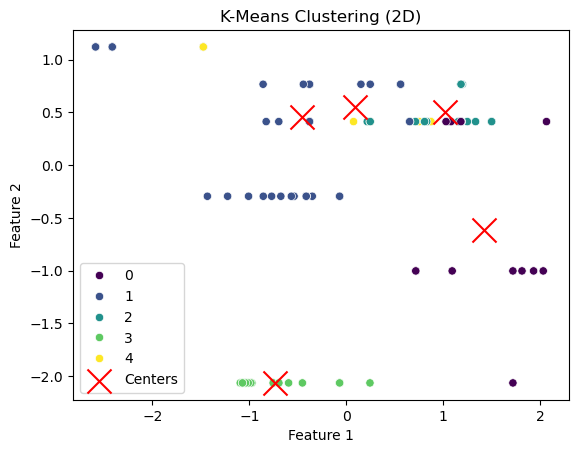

In [114]:
sns.scatterplot(x=product_features[:, 0], 
                y=product_features[:, 1], 
                hue=df_comp['cluster'], 
                palette='viridis')

# Mark cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='x', label='Centers')

plt.title("K-Means Clustering (2D)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [115]:
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 150 to 582
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   product_id                119 non-null    object        
 1   product_category_name     119 non-null    object        
 2   month_year                119 non-null    datetime64[ns]
 3   qty                       119 non-null    int64         
 4   total_price               119 non-null    float64       
 5   freight_price             119 non-null    float64       
 6   unit_price                119 non-null    float64       
 7   product_score             119 non-null    float64       
 8   customers                 119 non-null    int64         
 9   weekday                   119 non-null    int64         
 10  weekend                   119 non-null    int64         
 11  holiday                   119 non-null    int64         
 12  month                    

In [116]:
df_comp.isna().sum()

product_id                  0
product_category_name       0
month_year                  0
qty                         0
total_price                 0
freight_price               0
unit_price                  0
product_score               0
customers                   0
weekday                     0
weekend                     0
holiday                     0
month                       0
year                        0
s                           0
volume                      0
comp_1                      0
ps1                         0
fp1                         0
comp_2                      0
ps2                         0
fp2                         0
comp_3                      0
ps3                         0
fp3                         0
lag_price                   0
IsWeekend                   0
IsHoliday                   0
price_change                0
quarter                     0
comp1price_dff              0
comp2price_dff              0
comp3price_dff              0
fr1price_d

**Preprocessing**

In [117]:
df_comp.columns

Index(['product_id', 'product_category_name', 'month_year', 'qty',
       'total_price', 'freight_price', 'unit_price', 'product_score',
       'customers', 'weekday', 'weekend', 'holiday', 'month', 'year', 's',
       'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2', 'comp_3',
       'ps3', 'fp3', 'lag_price', 'IsWeekend', 'IsHoliday', 'price_change',
       'quarter', 'comp1price_dff', 'comp2price_dff', 'comp3price_dff',
       'fr1price_dff', 'fr2price_dff', 'fr3price_dff', 'price_ratio_1',
       'price_ratio_2', 'price_ratio_3', 'price_score_rel',
       'price_score_rel_1', 'price_score_rel_2', 'price_score_rel_3',
       'rolling_avg_price', 'rolling_avg_price_1', 'rolling_avg_price_2',
       'rolling_avg_price_3', 'pricescore_rolling_avg',
       'pricescore_rolling_avg_!', 'pricescore_rolling_avg_2',
       'pricescore_rolling_avg_3', 'cluster'],
      dtype='object')

In [118]:
df_comp.head()

product_id  product_category_name month_year  qty  total_price  \
150  computers5  computers_accessories 2017-01-10    1       167.00   
151  computers5  computers_accessories 2017-01-12    2       239.80   
152  computers5  computers_accessories 2018-01-01   57      5453.96   
153  computers5  computers_accessories 2018-01-02   45      3465.80   
154  computers5  computers_accessories 2018-01-03    6       528.00   

     freight_price  unit_price  product_score  customers  weekday  ...  \
150      14.920000  167.000000            3.5         31       22  ...   
151      13.440000  119.900000            3.5         35       21  ...   
152      12.239123   93.094894            3.5        152       23  ...   
153      11.513111   77.155000            3.5        202       20  ...   
154      17.553333   88.000000            3.5        127       22  ...   

     price_score_rel_3  rolling_avg_price  rolling_avg_price_1  \
150         584.500000                NaN                  NaN   
151         384.650000                NaN                  NaN   
152         341.748750         126.664965           153.732411   
153         275.492982          96.716631           151.833784   
154         283.583696          86.083298           147.218069   

     rolling_avg_price_2  rolling_avg_price_3  pricescore_rolling_avg  \
150                  NaN                  NaN                     NaN   
151                  NaN                  NaN                     NaN   
152           145.751515           124.847500              443.327376   
153           140.051515            95.418260              338.508209   
154           150.051515            85.792898              301.291543   

     pricescore_rolling_avg_!  pricescore_rolling_avg_2  \
150                       NaN                       NaN   
151                       NaN                       NaN   
152                645.676127                550.224849   
153                637.701892                570.248182   
154                618.315892                645.221515   

     pricescore_rolling_avg_3  cluster  
150                       NaN        0  
151                       NaN        3  
152                436.966250        3  
153                333.963911        3  
154                300.275143        3  

[5 rows x 52 columns]

In [119]:
pricing_cols = ['qty','unit_price', 'freight_price', 'comp_1', 'comp_2', 'comp_3','fp1','fp2','fp3', 'lag_price','comp1price_dff', 'comp2price_dff', 'comp3price_dff',
       'fr1price_dff', 'fr2price_dff', 'fr3price_dff', 'price_score_rel',
       'price_score_rel_1', 'price_score_rel_2', 'price_score_rel_3',
       'rolling_avg_price', 'rolling_avg_price_1', 'rolling_avg_price_2',
       'rolling_avg_price_3', 'pricescore_rolling_avg',
       'pricescore_rolling_avg_!', 'pricescore_rolling_avg_2',
       'pricescore_rolling_avg_3']
scaler = StandardScaler()
normalized_pricing = scaler.fit_transform(df_comp[pricing_cols])
normalized_pricing = pd.DataFrame(normalized_pricing, columns=pricing_cols)
#normalized_pricing = normalized_pricing.reindex(df.index)

In [120]:
normalized_pricing.head()
normalized_pricing.shape

(119, 28)

In [121]:
# cyclical encoding for 'month'
df_comp['month_sin'] = np.sin(2 * np.pi * df_comp['month'] / 12)
df_comp['month_cos'] = np.cos(2 * np.pi * df_comp['month'] / 12)
#df_comp = df_comp.reindex(df.index) 

In [122]:
df_comp[['month_sin','month_cos']].shape

(119, 2)

In [123]:
df_comp[['IsWeekend', 'IsHoliday','cluster','s']].shape

(119, 4)

In [124]:
df_comp = df_comp.drop(['quarter'], axis = 1)

In [125]:
'''df_processed = pd.concat([normalized_pricing, df_comp[['IsWeekend', 'IsHoliday','cluster','s']],
                          df_comp[['month_sin', 'month_cos']], one_hot_encoded], axis=1)'''

"df_processed = pd.concat([normalized_pricing, df_comp[['IsWeekend', 'IsHoliday','cluster','s']],\n                          df_comp[['month_sin', 'month_cos']], one_hot_encoded], axis=1)"

In [126]:
df_processed = pd.concat([one_hot_encoded_data[['product_category_name_computers_accessories','product_category_name_cool_stuff']], df_comp[['IsWeekend', 'IsHoliday','cluster','s']],
                          df_comp[['month_sin', 'month_cos']],normalized_pricing ], axis=1)

NameError: name 'one_hot_encoded_data' is not defined

In [ ]:
df_processed.isna().sum()

In [ ]:
df_comp.head()

In [129]:
numeric_features = ['qty',  'freight_price', 'comp_1', 'comp_2', 'comp_3', 'fp1', 
                    'fp2', 'fp3', 'lag_price', 'comp1price_dff', 'comp2price_dff', 
                    'comp3price_dff', 'fr1price_dff', 'fr2price_dff', 'fr3price_dff', 
                    'price_score_rel', 'price_score_rel_1', 'price_score_rel_2', 
                    'price_score_rel_3', 'rolling_avg_price', 'rolling_avg_price_1', 
                    'rolling_avg_price_2', 'rolling_avg_price_3', 'pricescore_rolling_avg', 
                    'pricescore_rolling_avg_!', 'pricescore_rolling_avg_2', 
                    'pricescore_rolling_avg_3']

categorical_features = ['product_category_name']
retain_features = ['cluster', 's','IsWeekend', 'IsHoliday']
#binary_features = ['IsWeekend', 'IsHoliday']

In [130]:
df_comp[['IsWeekend', 'IsHoliday']] = df_comp[['IsWeekend', 'IsHoliday']].replace({True: 1, False: 0})

In [131]:
numeric_feature_names = numeric_features
#binary_feature_names = binary_features
categorical_feature_names = categorical_features
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names, retain_features])

In [132]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  
            ('scaler', StandardScaler()) 
        ]), numeric_features),
        #('bin', SimpleImputer(strategy='most_frequent'), binary_features),  # Just impute binary columns
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  
            ('encoder', OneHotEncoder(drop='first')) 
        ]), categorical_features),
    ],
    remainder='passthrough'  
)


In [133]:
X = df_comp[all_feature_names]
y = df_comp['unit_price']  

In [134]:
X.head()

qty  freight_price      comp_1      comp_2      comp_3        fp1  \
150    1      14.920000  154.695882  167.000000  167.000000  43.881176   
151    2      13.440000  149.990000  119.900000  109.900000  38.570000   
152   57      12.239123  156.511351  150.354546   97.642500  36.807209   
153   45      11.513111  149.000000  149.900000   78.712281  41.163226   
154    6      17.553333  136.142857  149.900000   81.023913  48.047500   

           fp2        fp3   lag_price  comp1price_dff  ...  \
150  14.920000  14.920000  166.950000       12.304118  ...   
151  13.440000  25.249167  119.850000      -30.090000  ...   
152  22.547727  14.846552  119.900000      -63.416458  ...   
153  26.552899  14.535915   93.094894      -71.845000  ...   
154  28.475882  18.221481   77.155000      -48.142857  ...   

     rolling_avg_price_3  pricescore_rolling_avg  pricescore_rolling_avg_!  \
150                  NaN                     NaN                       NaN   
151                  NaN                     NaN                       NaN   
152           124.847500              443.327376                645.676127   
153            95.418260              338.508209                637.701892   
154            85.792898              301.291543                618.315892   

     pricescore_rolling_avg_2  pricescore_rolling_avg_3  \
150                       NaN                       NaN   
151                       NaN                       NaN   
152                550.224849                436.966250   
153                570.248182                333.963911   
154                645.221515                300.275143   

     product_category_name  cluster          s  IsWeekend  IsHoliday  
150  computers_accessories        0  33.333333          0          0  
151  computers_accessories        3  66.666667          0          0  
152  computers_accessories        3  45.967742          0          1  
153  computers_accessories        3  36.290323          0          0  
154  computers_accessories        3   4.838710          0          0  

[5 rows x 32 columns]

In [135]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_processed = pipeline.fit_transform(X)

In [136]:
X.shape

(119, 32)

In [137]:
X_processed.shape

(119, 32)

In [138]:
X_processed

array([[-0.83108211, -0.69801923,  1.34242417, ..., 33.33333333,
         0.        ,  0.        ],
       [-0.75375704, -0.84181681,  1.16207822, ..., 66.66666667,
         0.        ,  0.        ],
       [ 3.49912211, -0.95849467,  1.41199932, ..., 45.96774194,
         0.        ,  1.        ],
       ...,
       [-0.83108211, -0.81461186, -0.75409751, ...,  8.70870871,
         0.        ,  0.        ],
       [-0.75375704, -0.12865856, -0.75409751, ..., 17.41741742,
         0.        ,  0.        ],
       [-0.67643196, -0.2164269 , -1.14218697, ..., 24.32432432,
         0.        ,  0.        ]])

In [139]:
all_feature_names

array(['qty', 'freight_price', 'comp_1', 'comp_2', 'comp_3', 'fp1', 'fp2',
       'fp3', 'lag_price', 'comp1price_dff', 'comp2price_dff',
       'comp3price_dff', 'fr1price_dff', 'fr2price_dff', 'fr3price_dff',
       'price_score_rel', 'price_score_rel_1', 'price_score_rel_2',
       'price_score_rel_3', 'rolling_avg_price', 'rolling_avg_price_1',
       'rolling_avg_price_2', 'rolling_avg_price_3',
       'pricescore_rolling_avg', 'pricescore_rolling_avg_!',
       'pricescore_rolling_avg_2', 'pricescore_rolling_avg_3',
       'product_category_name', 'cluster', 's', 'IsWeekend', 'IsHoliday'],
      dtype='<U24')

In [140]:
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)

In [141]:
X_processed_df

qty  freight_price    comp_1    comp_2    comp_3       fp1  \
0   -0.831082      -0.698019  1.342424  1.515688  1.973410  1.012560   
1   -0.753757      -0.841817  1.162078 -0.532506  0.414962  0.621349   
2    3.499122      -0.958495  1.411999  0.791843  0.080414  0.491505   
3    2.571221      -1.029034  1.124138  0.772076 -0.436254  0.812361   
4   -0.444457      -0.442163  0.631407  0.772076 -0.373162  1.319444   
..        ...            ...       ...       ...       ...       ...   
114 -0.676432      -0.664337 -0.754098 -0.093731  0.144485 -1.095131   
115 -0.676432      -0.540619 -0.754098 -0.093731 -1.779420 -1.001340   
116 -0.831082      -0.814612 -0.754098 -0.093731  0.144485 -1.209056   
117 -0.753757      -0.128659 -0.754098 -0.093731 -1.629307 -0.689029   
118 -0.676432      -0.216427 -1.142187 -0.093731 -1.629307 -0.755567   

          fp2       fp3  lag_price  comp1price_dff  ...  rolling_avg_price_3  \
0   -1.059991 -0.532501   1.620604        0.606817  ...            -3.043996   
1   -1.237995  0.800717   0.197083       -0.688214  ...            -3.043996   
2   -0.142580 -0.541981   0.198595       -1.706251  ...             1.035445   
3    0.339134 -0.582076  -0.611546       -1.963721  ...             0.073833   
4    0.570418 -0.106368  -1.093303       -1.239682  ...            -0.240679   
..        ...       ...        ...             ...  ...                  ...   
114  0.223324 -0.487755  -0.403153        0.230958  ...             0.223217   
115 -0.760511 -0.324353  -0.403153        0.230958  ...            -0.544546   
116 -0.844702 -0.687388  -0.403153        0.230958  ...            -0.544546   
117 -0.630616 -0.360039  -0.403153        0.230958  ...            -1.252404   
118 -0.029250 -0.542181  -0.403153        0.230958  ...            -1.192499   

     pricescore_rolling_avg  pricescore_rolling_avg_!  \
0                 -3.259197                 -4.115948   
1                 -3.259197                 -4.115948   
2                 -0.054136                  1.263480   
3                 -0.811933                  1.197043   
4                 -1.080993                  1.035529   
..                      ...                       ...   
114               -0.223087                 -0.617083   
115               -0.223087                 -0.617083   
116               -0.223087                 -0.617083   
117               -0.223087                 -0.617083   
118               -0.325582                 -0.735201   

     pricescore_rolling_avg_2  pricescore_rolling_avg_3  \
0                   -5.074215                 -2.831599   
1                   -5.074215                 -2.831599   
2                   -0.010642                  0.521859   
3                    0.173628                 -0.268624   
4                    0.863587                 -0.527165   
..                        ...                       ...   
114                 -0.062188                  0.391330   
115                  0.069718                 -0.350933   
116                  0.069718                 -0.350933   
117                  0.069718                 -1.031290   
118                  0.069718                 -0.969383   

     product_category_name  cluster          s  IsWeekend  IsHoliday  
0                      0.0      0.0  33.333333        0.0        0.0  
1                      0.0      3.0  66.666667        0.0        0.0  
2                      0.0      3.0  45.967742        0.0        1.0  
3                      0.0      3.0  36.290323        0.0        0.0  
4                      0.0      3.0   4.838710        0.0        0.0  
..                     ...      ...        ...        ...        ...  
114                    1.0      1.0   2.702703        0.0        0.0  
115                    1.0      1.0  33.333333        0.0        1.0  
116                    1.0      1.0   8.708709        0.0        0.0  
117                    1.0      1.0  17.417417        0.0        0.0  
118      

**Train test split**

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [143]:
num_df = X_processed_df.select_dtypes(include = ['int64','float64'])

In [144]:
model = RandomForestRegressor()

In [145]:
rfe = RFE(estimator=model, n_features_to_select=10)  # Adjust 'n_features_to_select' as needed
X_train_rfe = rfe.fit_transform(X_train, y_train)

In [146]:
selected_features = rfe.support_ 
selected_features

array([False, False, False, False,  True,  True, False, False,  True,
       False,  True, False, False, False, False,  True, False, False,
       False,  True, False,  True,  True, False, False, False,  True,
       False,  True, False, False, False])

In [147]:
model.fit(X_train_rfe, y_train)

RandomForestRegressor()

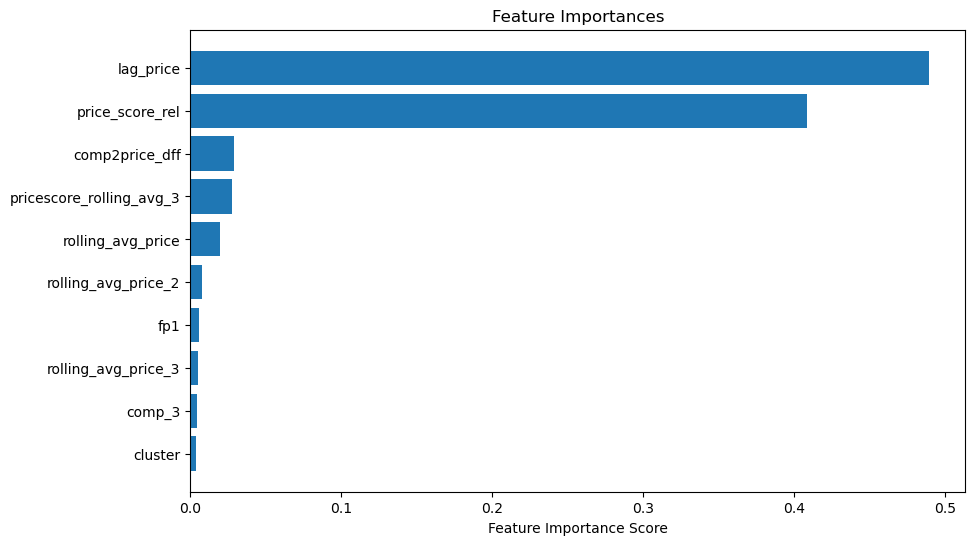

In [148]:
feature_importances = model.feature_importances_

# Get the feature names corresponding to the selected features
selected_features_names = np.array(all_feature_names)[rfe.support_]

# Sort the features by importance (optional, for better visualization)
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), feature_importances[indices], align="center")
plt.yticks(range(len(indices)), selected_features_names[indices])
plt.xlabel("Feature Importance Score")
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

In [149]:
X_test_rfe = rfe.transform(X_test)  # Transform test set with the same selected features
y_pred = model.predict(X_test_rfe)

In [150]:
X_test_df.head()

NameError: name 'X_test_df' is not defined

In [ ]:
X_test_df.shape

In [ ]:
y_test_df = pd.DataFrame(y_test)

In [ ]:
y_test_df.shape

In [ ]:
X_test_df = pd.DataFrame(X_test, columns=all_feature_names)  # Ensure the correct columns
X_test_df['predicted_price'] = y_pred

# Include key columns like 'product_category_name', 'year', 'month'
#X_test_df_with_keys = X_test_df[['product_category_name', 'year', 'month', 'predicted_price']]

# Step 6: Merge predicted prices into df_agg
#df_agg_comp = df_agg_comp.merge(X_test_df_with_keys, on=['product_category_name', 'year', 'month'], how='left')

In [ ]:
X_test_df.head()

In [151]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on the test set
y_pred = model.predict(X_test_rfe)

# Calculate MAE, MSE, RMSE, and R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 4.982322817020823
Mean Squared Error (MSE): 63.3738953189025
Root Mean Squared Error (RMSE): 7.960772281563045
R² Score: 0.9471807599342111


### 8.3  Seasonality Pricing Model

In [152]:
df_cleaned['product_category_name'].unique()

array(['bed_bath_table', 'computers_accessories', 'consoles_games',
       'cool_stuff', 'furniture_decor', 'garden_tools', 'health_beauty',
       'perfumery', 'watches_gifts'], dtype=object)

In [153]:
exclude_categories = ['bed_bath_table', 'computers_accessories', 'consoles_games']

#create dataframe with the remaining categories
df_season = df_cleaned.copy()
df_season = df_cleaned[~df_cleaned['product_category_name'].isin(exclude_categories)]

In [154]:
df_season[['IsWeekend', 'IsHoliday']] = df_season[['IsWeekend', 'IsHoliday']].replace({True: 1, False: 0})

In [155]:
df_agg = df_season.groupby(['product_category_name','year','month']).agg({
    'qty': 'sum',  
    'IsWeekend' : 'sum',
    'IsHoliday' : 'sum',
    'unit_price': 'mean',  
    'freight_price' : 'mean',
    'lag_price' : 'mean',
    'price_change' : 'mean',
    'comp1price_dff' : 'mean',
    'comp2price_dff' : 'mean',
    'comp3price_dff' : 'mean',
    'fr1price_dff' : 'mean', 
    'fr2price_dff' : 'mean', 
    'fr3price_dff' : 'mean'
}).reset_index()

In [156]:
df_agg['sine_month'] = np.sin(2 * np.pi * df_agg['month'] / 12)
df_agg['cosine_month'] = np.cos(2 * np.pi * df_agg['month'] / 12)

In [157]:
df_agg.head()

product_category_name  year  month  qty  IsWeekend  IsHoliday  unit_price  \
0            cool_stuff  2017      2    7          0          1   85.704286   
1            cool_stuff  2017      3   22          0          0  114.990000   
2            cool_stuff  2017      4   33          0          0  109.990000   
3            cool_stuff  2017      5   58          0          0  109.990000   
4            cool_stuff  2017      6   42          0          0  109.990000   

   freight_price   lag_price  price_change  comp1price_dff  comp2price_dff  \
0      21.971429   85.654286      0.050000             0.0             0.0   
1      17.711518  107.822143      7.167857            15.0           -15.0   
2      17.589594  109.973333      0.016667            10.0           -20.0   
3      16.290303  109.990000      0.000000            10.0           -20.0   
4      17.126171  109.990000      0.000000            10.0           -20.0   

   comp3price_dff  fr1price_dff  fr2price_dff  fr3price_dff    sine_month  \
0             0.0      0.000000      0.000000           0.0  8.660254e-01   
1             0.0      1.067232     -1.067232           0.0  1.000000e+00   
2             0.0      3.387241      0.193165           0.0  8.660254e-01   
3             0.0      1.269394     -1.982475           0.0  5.000000e-01   
4             0.0      3.299743      0.064995           0.0  1.224647e-16   

   cosine_month  
0  5.000000e-01  
1  6.123234e-17  
2 -5.000000e-01  
3 -8.660254e-01  
4 -1.000000e+00

In [158]:
df_agg['price_elasticity'] = (
    df_agg.groupby('product_category_name')['qty'].pct_change() / 
    (df_agg.groupby('product_category_name')['unit_price'].pct_change() + 1e-10)  # Avoid division by zero
)

In [159]:
print(np.isinf(df_agg[['unit_price', 'price_elasticity', 'sine_month']]).sum())

unit_price          0
price_elasticity    0
sine_month          0
dtype: int64


In [160]:
df_agg['lagged_qty'] = df_agg['qty'].shift(1)

In [161]:
#df_season['quarter'] = pd.to_datetime(df_season['month_year']).dt.quarter

In [162]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_category_name  103 non-null    object 
 1   year                   103 non-null    int64  
 2   month                  103 non-null    int64  
 3   qty                    103 non-null    int64  
 4   IsWeekend              103 non-null    int64  
 5   IsHoliday              103 non-null    int64  
 6   unit_price             103 non-null    float64
 7   freight_price          103 non-null    float64
 8   lag_price              103 non-null    float64
 9   price_change           103 non-null    float64
 10  comp1price_dff         103 non-null    float64
 11  comp2price_dff         103 non-null    float64
 12  comp3price_dff         103 non-null    float64
 13  fr1price_dff           103 non-null    float64
 14  fr2price_dff           103 non-null    float64
 15  fr3pri

In [163]:
df_agg.isna().sum()

product_category_name    0
year                     0
month                    0
qty                      0
IsWeekend                0
IsHoliday                0
unit_price               0
freight_price            0
lag_price                0
price_change             0
comp1price_dff           0
comp2price_dff           0
comp3price_dff           0
fr1price_dff             0
fr2price_dff             0
fr3price_dff             0
sine_month               0
cosine_month             0
price_elasticity         6
lagged_qty               1
dtype: int64

In [164]:
df_agg = df_agg.fillna(0)

In [165]:
df_agg.head()

product_category_name  year  month  qty  IsWeekend  IsHoliday  unit_price  \
0            cool_stuff  2017      2    7          0          1   85.704286   
1            cool_stuff  2017      3   22          0          0  114.990000   
2            cool_stuff  2017      4   33          0          0  109.990000   
3            cool_stuff  2017      5   58          0          0  109.990000   
4            cool_stuff  2017      6   42          0          0  109.990000   

   freight_price   lag_price  price_change  comp1price_dff  comp2price_dff  \
0      21.971429   85.654286      0.050000             0.0             0.0   
1      17.711518  107.822143      7.167857            15.0           -15.0   
2      17.589594  109.973333      0.016667            10.0           -20.0   
3      16.290303  109.990000      0.000000            10.0           -20.0   
4      17.126171  109.990000      0.000000            10.0           -20.0   

   comp3price_dff  fr1price_dff  fr2price_dff  fr3price_dff    sine_month  \
0             0.0      0.000000      0.000000           0.0  8.660254e-01   
1             0.0      1.067232     -1.067232           0.0  1.000000e+00   
2             0.0      3.387241      0.193165           0.0  8.660254e-01   
3             0.0      1.269394     -1.982475           0.0  5.000000e-01   
4             0.0      3.299743      0.064995           0.0  1.224647e-16   

   cosine_month  price_elasticity  lagged_qty  
0  5.000000e-01      0.000000e+00         0.0  
1  6.123234e-17      6.271045e+00         7.0  
2 -5.000000e-01     -1.149900e+01        22.0  
3 -8.660254e-01      7.575758e+09        33.0  
4 -1.000000e+00     -2.758621e+09        58.0

In [166]:
df_agg.isna().sum()

product_category_name    0
year                     0
month                    0
qty                      0
IsWeekend                0
IsHoliday                0
unit_price               0
freight_price            0
lag_price                0
price_change             0
comp1price_dff           0
comp2price_dff           0
comp3price_dff           0
fr1price_dff             0
fr2price_dff             0
fr3price_dff             0
sine_month               0
cosine_month             0
price_elasticity         0
lagged_qty               0
dtype: int64

In [167]:
scaler_season = StandardScaler()
product_features_s = scaler_season.fit_transform(df_agg[['unit_price', 'price_elasticity', 'sine_month']])

kmeans = KMeans(n_clusters=5, random_state=42)
df_agg['cluster'] = kmeans.fit_predict(product_features_s)

In [168]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_category_name  103 non-null    object 
 1   year                   103 non-null    int64  
 2   month                  103 non-null    int64  
 3   qty                    103 non-null    int64  
 4   IsWeekend              103 non-null    int64  
 5   IsHoliday              103 non-null    int64  
 6   unit_price             103 non-null    float64
 7   freight_price          103 non-null    float64
 8   lag_price              103 non-null    float64
 9   price_change           103 non-null    float64
 10  comp1price_dff         103 non-null    float64
 11  comp2price_dff         103 non-null    float64
 12  comp3price_dff         103 non-null    float64
 13  fr1price_dff           103 non-null    float64
 14  fr2price_dff           103 non-null    float64
 15  fr3pri

In [169]:
df_agg.columns

Index(['product_category_name', 'year', 'month', 'qty', 'IsWeekend',
       'IsHoliday', 'unit_price', 'freight_price', 'lag_price', 'price_change',
       'comp1price_dff', 'comp2price_dff', 'comp3price_dff', 'fr1price_dff',
       'fr2price_dff', 'fr3price_dff', 'sine_month', 'cosine_month',
       'price_elasticity', 'lagged_qty', 'cluster'],
      dtype='object')

**Preprocessing**

In [170]:
numeric_features_s = ['qty', 'freight_price', 'lag_price', 'price_change',
       'comp1price_dff', 'comp2price_dff', 'comp3price_dff', 'fr1price_dff',
       'fr2price_dff', 'fr3price_dff', 'sine_month', 'cosine_month',
       'price_elasticity', 'lagged_qty']

categorical_features_s = ['product_category_name']
retain_features_s = ['year', 'month','cluster', 'IsWeekend', 'IsHoliday']

In [171]:
all_feature_names_s = np.concatenate([numeric_features_s, categorical_features_s, retain_features_s])

In [172]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  
            ('scaler', StandardScaler()) 
        ]), numeric_features_s),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  
            ('encoder', OneHotEncoder(drop='first')) 
        ]), categorical_features_s),
    ],
    remainder='passthrough'  
)

In [173]:
X = df_agg[all_feature_names_s]
y = df_agg['unit_price']  

In [174]:
X.columns

Index(['qty', 'freight_price', 'lag_price', 'price_change', 'comp1price_dff',
       'comp2price_dff', 'comp3price_dff', 'fr1price_dff', 'fr2price_dff',
       'fr3price_dff', 'sine_month', 'cosine_month', 'price_elasticity',
       'lagged_qty', 'product_category_name', 'year', 'month', 'cluster',
       'IsWeekend', 'IsHoliday'],
      dtype='object')

In [175]:
X.shape

(103, 20)

In [176]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [177]:
X_processed = pipeline.fit_transform(X)


In [178]:
X_processed.shape

(103, 24)

In [179]:
# Get the names of the transformed numeric features
numeric_feature_names = numeric_features_s  # These remain unchanged

# Get the names of the transformed categorical features
categorical_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features_s)

# Combine all feature names, including retain features
new_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names, retain_features_s])

In [180]:
new_feature_names

array(['qty', 'freight_price', 'lag_price', 'price_change',
       'comp1price_dff', 'comp2price_dff', 'comp3price_dff',
       'fr1price_dff', 'fr2price_dff', 'fr3price_dff', 'sine_month',
       'cosine_month', 'price_elasticity', 'lagged_qty',
       'product_category_name_furniture_decor',
       'product_category_name_garden_tools',
       'product_category_name_health_beauty',
       'product_category_name_perfumery',
       'product_category_name_watches_gifts', 'year', 'month', 'cluster',
       'IsWeekend', 'IsHoliday'], dtype=object)

In [181]:
X_processed_df = pd.DataFrame(X_processed, columns=new_feature_names)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [183]:
model = RandomForestRegressor()
rfe = RFE(estimator=model, n_features_to_select=6)  
X_train_rfe = rfe.fit_transform(X_train, y_train)
model.fit(X_train_rfe, y_train)


RandomForestRegressor()

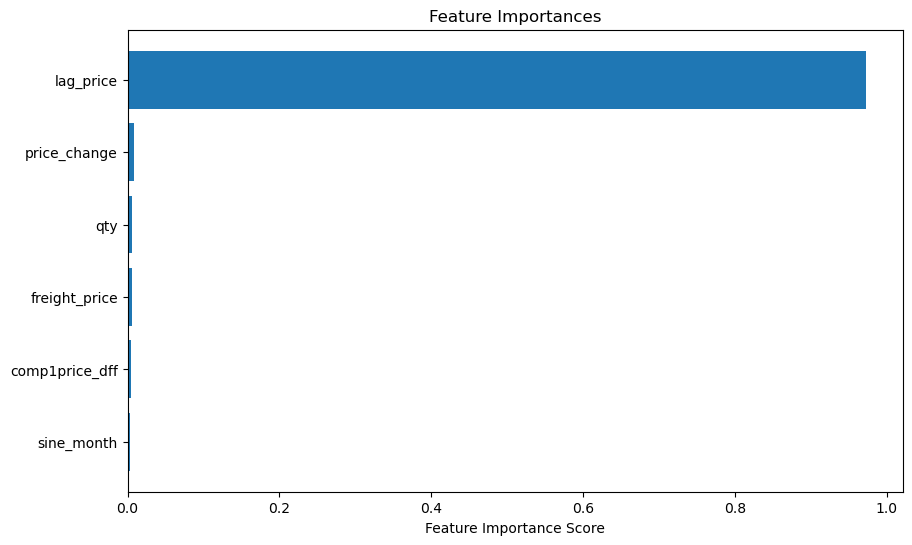

In [184]:
feature_importances = model.feature_importances_

# Get the feature names corresponding to the selected features
selected_features_names = np.array(new_feature_names)[rfe.support_]

# Sort the features by importance (optional, for better visualization)
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), feature_importances[indices], align="center")
plt.yticks(range(len(indices)), selected_features_names[indices])
plt.xlabel("Feature Importance Score")
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()


In [185]:
X_test_rfe = rfe.transform(X_test)  # Transform test set with the same selected features
y_pred = model.predict(X_test_rfe)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [186]:
# Predict on the test set
y_pred = model.predict(X_test_rfe)

# Calculate MAE, MSE, RMSE, and R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)



In [187]:
# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 3.6368657137319347
Mean Squared Error (MSE): 27.554290302382235
Root Mean Squared Error (RMSE): 5.249218065805824
R² Score: 0.976238326263476
